## Hands-on session 1.1 - ground-up construction of a simple advective model

This notebook covers the basic construction of a simple advective model. 

Demonstrated concepts:

- Initializing an RKWrapper object 
- Setting up I/O filepaths
- Setting up MPI basic options 
- Default normalization
- Creating a simple spatial grid 
- Simple variables (including those that live on the staggered grid)
- Matrix terms using divergence and gradient stencils 
- Time integration setup

In [25]:
from RMK_support import RKWrapper ,Grid
import RMK_support.simple_containers as sc
import RMK_support.IO_support as io

import numpy as np
import holoviews as hv
import matplotlib.pyplot as plt

### Wrapper initialization

The wrapper is the central Python object controlling the setup of ReMKiT1D runs

In [26]:
rk = RKWrapper()

### Global parameters for writing the files

The default value for the ReMKiT1D json input is `config.json`, and most ReMKiT1D input routines search for this file, unless a different file name is specified in the command line.
HDF5 files are by default also assumed to be in the local directory.

In [27]:
rk.jsonFilepath = "./config.json" # Default value
hdf5Filepath = "./RMKOutput/day_1_1/"
rk.setHDF5Path(hdf5Filepath) # The input and output location of any HDF5 files used/generated by the code

#### MPI

For a simple case using only built-in operators and no electron kinetics, the following is enough to set up parallelization options. Here using 4 processors in the spatial direction.

In [28]:
rk.setMPIData(numProcsX=4)

### Normalization

ReMKiT1D has a set of default normalizations derived from a reference density ($m^{-3}$), temperature (in eV), and a reference ion charge. This normalization is inherited from SOL-KiT, and is geared towards electron kinetics simulations. The normalization is used explicitly in only a limited part of the functionality of the code, so the user can in principle use their own normalization. 

In [29]:
rk.setNormDensity(1.0e19) #n_0
rk.setNormTemperature(10.0) #T_0
rk.setNormRefZ(1.0) # reference ion charge for e-i collision time

To query what the default normalized quantities are, the user can import the sk_normalization module. The output of the `calculateNorms` function is a dictionary with the default normalization values given in SI. For more information see the documentation of the sk_normalization module or the ReMKiT1D code paper.

In [30]:
import RMK_support.sk_normalization as skn 

skn.calculateNorms(Te=10.0,ne=1.0e19,Z=1.0)

{'time': 7.220495388899917e-08,
 'velGrid': 1875539.6133072434,
 'speed': 1875539.6133072434,
 'EField': 147.6851265098392,
 'heatFlux': 30049520.576485995,
 'crossSection': 7.384256325491959e-19,
 'length': 0.13542325129584085}

### Grid initialization

The spatial grid in ReMKiT1D consists of $N_x$ cells, with variables allowed to live on either cell centres, or cell edges (also referred to as the dual or staggered grid). By convention, we add the suffix `_dual` to variables that live on the the dual/staggered grid.

**NOTE**: Unless the grid is periodic, there is always one fewer cell edge than there are cell centres.

Below we initialize a grid of 512 cells with uniform width. 

In [32]:
xGridWidths = 0.025*np.ones(512) # in normalized units unless specified as meters in Grid constructor (note: this will then explicitly assume that length is normalized to the default value in order to convert to meters)

gridObj = Grid(xGridWidths, interpretXGridAsWidths=True)

rk.grid = gridObj

### The equations

The equations we want to write a ReMKiT1D script for in this case are the following

$$\frac{\partial n}{\partial t} = - \frac{\partial \Gamma}{\partial x}$$

$$m_i \frac{\partial \Gamma}{\partial t} = - \frac{\partial (nkT)}{\partial x}$$

where $n$ is a density, $\Gamma$ is a flux, $m_i$ is the mass of the species, and $T$ is a temperature. We begin by normalizing these equations using the default normalizations:

$n \rightarrow n n_0$ for density

$\Gamma \rightarrow \Gamma n_0 u_0 = \Gamma n_0 \sqrt{m_eeT_0/2}$ for the particle flux

$kT \rightarrow T eT_0$ for the temperature

$x \rightarrow xx_0$ for the distance

$t \rightarrow tt_0$ for the time 

with $u_0=x_0/t_0$.

After applying the normalization, the resulting equations are 

$\frac{\partial n}{\partial t} = - \frac{\partial \Gamma}{\partial x}$

$\frac{\partial \Gamma}{\partial t} = - \frac{m_e}{2m_i}\frac{\partial (nT)}{\partial x}$

which are now in normalized units and can be easily implemented. 

**NOTE**: As noted above, we didn't have to use the default normalization. This example would work for whatever consistent set of normalizations we choose. The default ones are simply convenient.


### Variables

Variables can be added directly to the wrapper. For example, here we want a Gaussian perturbation in density, and a constant temperature as initial conditions

In [36]:
n = 1 + np.exp(-(gridObj.xGrid-np.mean(gridObj.xGrid))**2) # A Gaussian perturbation
T = np.ones(len(gridObj.xGrid)) # Constant temperature

# These will add both the variable 'v' and 'v_dual'
rk.addVarAndDual('n',n,isCommunicated=True) # If in doubt, set isCommunicated to True, especially if the variable appears under differential operators
rk.addVarAndDual('T',T,isDerived=True) # isDerived removes the variable from the implicit vector. No derivation rule means that the variable will stay constant.

Both density and temperature naturally live in cell centres so "n_dual" and "T_dual" will be linearly interpolated from neighbouring cell edges.

Unlike density and temperature, fluxes live naturally on cell edges and so we would like to evolve the dual variable and interpolate the variable in the cell centres. This can be specified by the `primaryOnDualGrid` flag

In [37]:
rk.addVarAndDual('G',isCommunicated=True,primaryOnDualGrid=True) # not passing a value initializes the variable as 0

To demonstrate how a derivation rule can be set, we use the in-built `flowSpeedFromFlux` derivation, which simply takes two variables and returns their ratio. For the default normalization, when this derivation is passed a flux and density it will return the correct normalized flow speed.

The flow speed is added below, with "u_dual" calculated using the derivation, and "u" interpolated on cell centers.

In [40]:
rk.addVarAndDual('u',isDerived=True,derivationRule=sc.derivationRule("flowSpeedFromFlux",["G_dual","n_dual"]),primaryOnDualGrid=True,isCommunicated=True)

Finally, we add the scalar "time" variable that the simulation will recognize and use to store elapsed time.

In [41]:
rk.addVar('time',isDerived=True,isScalar=True)

### Models and Terms

We now proceed to add the terms in the equations we wish to solve. 

The first term to add is the divergence of the flux on the RHS of the first equation 

$- \frac{\partial \Gamma}{\partial x}$

The variable evolved by this term is the density "n". When discretized, in matrix form, this term looks like

$ - S^{div}_{ij}\Gamma_j$
where $S^{div}_{ij}$ is the corresponding divergence stencil on the staggered grid. The natural choice for the implicit variable here is $\Gamma_j$, which corresponds to "G_dual". 

This is encoded as a Model with a single term

In [43]:
# adding the div(u) term to the n equation
newModel = sc.CustomModel(modelTag="nAdvection")

# the implicit variable is 'G_dual' since it is the primary variable 
# and the stencil is staggered because 'n' and 'G_dual' live on different grids
divFluxTerm = sc.GeneralMatrixTerm(evolvedVar='n',implicitVar='G_dual',customNormConst=-1.0,stencilData=sc.staggeredDivStencil())
newModel.addTerm("divFlux",divFluxTerm)
rk.addModel(newModel)


Checking terms in model nAdvection:
   Checking term divFlux


The second term to be added is the pressure gradient term in the second equation, evolving $\Gamma$ ("G_dual")

$- \frac{m_e}{2m_i}\frac{\partial (nT)}{\partial x}$

which when discretized produces a matrix 

$-\frac{m_e}{2m_i} S^{grad}_{ij}n_jT_j$

This time we have two variables under the differential operator. One of them will have to be lagged in the implicit solve. In this case, since temperature is constant (it might as well not be a variable!), we choose density as the implicit variable and implement the term as follows, putting temperature as a required column variable, meaning that it will also be acted on by the gradient stencil.

In [45]:

# adding the pressure gradient term to the G_dual equation
newModel = sc.CustomModel(modelTag='pGrad')

#Required variable data for pressure 
vData = sc.VarData(reqColVars=['T']) 

massRatio = 1/1836

gradTerm = sc.GeneralMatrixTerm(evolvedVar='G_dual',implicitVar='n',customNormConst=-massRatio/2,stencilData=sc.staggeredGradStencil(),varData=vData)

newModel.addTerm("gradTerm",gradTerm)
rk.addModel(newModel)

Checking terms in model pGrad:
   Checking term gradTerm


### Time integration options

Here we add time integrators to the wrapper. In this example this is the basic implicit Backwards Euler method that deals with non-linear terms using fixed-point iterations. 

The integrator below will aim to achieve a relative non-linear error of $10^{-12}$ or an absolute error of $10\epsilon$ where $\epsilon$ is effectively machine precision in the two evolved variables 'n' and 'G_dual'.


In [46]:
# the implicit BDE integrator that checks convergence based on the variables 'n' and 'G_dual'
rk.addIntegrator("BE",sc.picardBDEIntegrator(nonlinTol=1e-12,absTol=10.0,convergenceVars=['n','G_dual']) )

The time step for this simulation is set to $0.1t_0$, where $t_0$ is the normalized time. It is referred to as the `initialTimestep` because in general it might be split or scaled in accordance to some additional rule.

In [47]:
rk.setIntegratorGlobalData(initialTimestep=0.1) 

In general ReMKiT1D supports splitting the integration into multiple steps through defining multiple integrations steps that can each use different integrators and evolve different models and/or groups of terms. 

For this basic example, we have only a single integration step that evolves both models we've added

In [48]:
# a single integration step evolving all models
bdeStep = sc.IntegrationStep("BE")

for tag in rk.modelTags():
    bdeStep.addModel(tag)

rk.addIntegrationStep("StepBDE",bdeStep.dict())

### Time loop options

Finally, the outer loop in time must be specified. In this case it is set to have a fixed number of 10000 time steps and to output every 200 steps. 

In [49]:
rk.setFixedNumTimesteps(10000)
rk.setFixedStepOutput(200)

### Create config 

Once the wrapper is ready, its state can be recorded in a `config.json` file which ReMKiT1D can read and build the requested simulation. 

In order to run the simulation from the Docker container used in this workshop run 

`mpirun -np 4 /home/ReMKiT1D/build/src/executables/ReMKiT1D/ReMKiT1D`

from the folder containing this notebook. 

In [50]:
rk.writeConfigFile()

### Set global plotting options

In [51]:
hv.extension('matplotlib')
%matplotlib inline 
plt.rcParams['figure.dpi'] = 150
hv.output(size=150,dpi=150)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

### Load data from ReMKiT1D output files

In [52]:
numFiles = 50
loadpath = hdf5Filepath
loadFilenames = [loadpath+f'ReMKiT1DVarOutput_{i}.h5' for i in range(numFiles+1)]
loadedData = io.loadFromHDF5(rk.varCont,filepaths=loadFilenames)
loadedData

<xarray.Dataset>
Dimensions:  (x: 512, h: 1, v: 1, time: 51)
Coordinates:
  * x        (x) float64 0.0125 0.0375 0.0625 0.0875 ... 12.71 12.74 12.76 12.79
  * h        (h) int64 0
  * v        (v) float64 1.0
  * time     (time) float64 0.0 20.0 40.0 60.0 80.0 ... 940.0 960.0 980.0 1e+03
Data variables:
    n        (time, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    n_dual   (time, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    T        (time, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    T_dual   (time, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    G_dual   (time, x) float64 0.0 0.0 0.0 0.0 ... -6.65e-10 -3.271e-10 0.0
    G        (time, x) float64 0.0 0.0 0.0 ... -8.449e-10 -4.96e-10 -1.581e-10
    u_dual   (time, x) float64 0.0 0.0 0.0 0.0 ... -6.65e-10 -3.271e-10 0.0
    u        (time, x) float64 0.0 0.0 0.0 ... -8.449e-10 -4.96e-10 -1.581e-10

### Compare with analytic solution

In [53]:
wave_speed= np.sqrt(massRatio/2)
n_analytic=np.zeros((numFiles+1,gridObj.numX()))
times = loadedData.coords['time'].data
L = sum(xGridWidths)
for i in range(numFiles+1):
        leftPositionMod = (gridObj.xGrid-wave_speed*times[i]) % L
        leftPosition = np.where(leftPositionMod > 0,leftPositionMod,leftPositionMod+L)
        rightPosition = (gridObj.xGrid+wave_speed*times[i]) % L
        n_analytic[i,:] =1 + 0.5*(np.exp(-(leftPosition-np.mean(gridObj.xGrid))**2) + np.exp(-(rightPosition-np.mean(gridObj.xGrid))**2)) 


:HoloMap   [time]
   :Overlay
      .Scatter.Simulation    :Scatter   [x]   (n)
      .Curve.Analytic_result :Curve   [x]   (y)
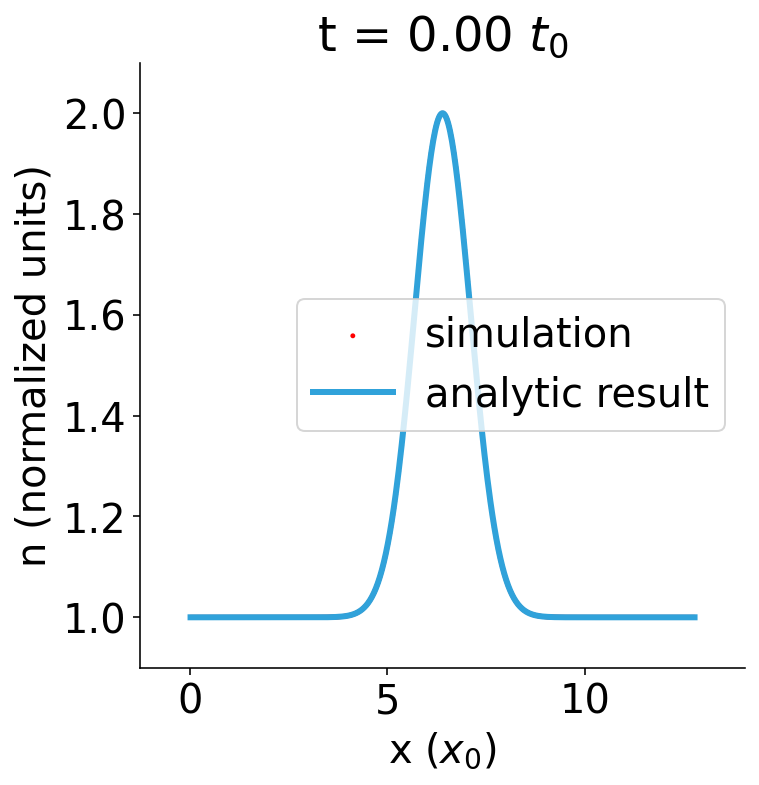
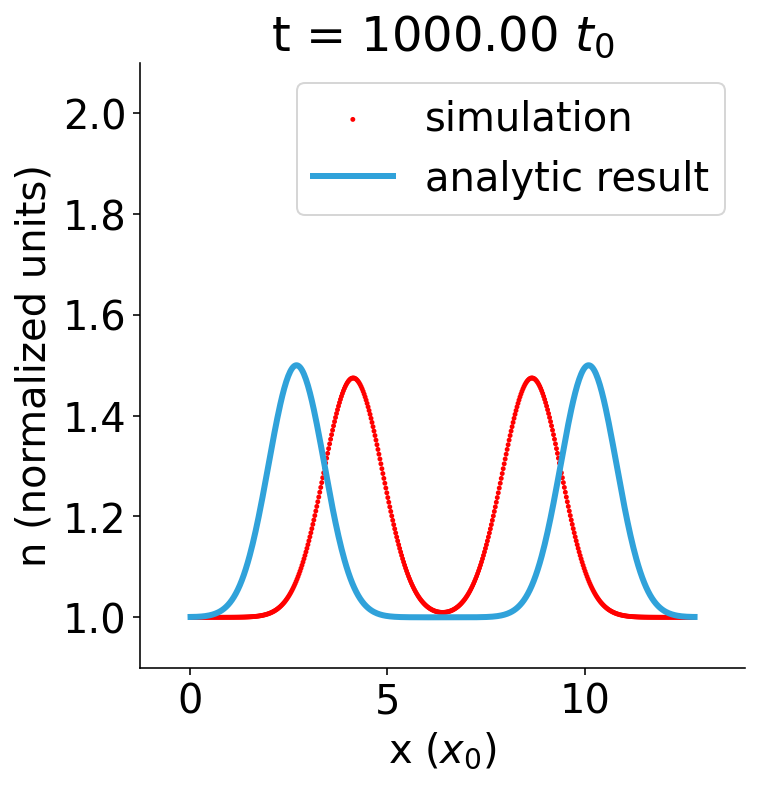
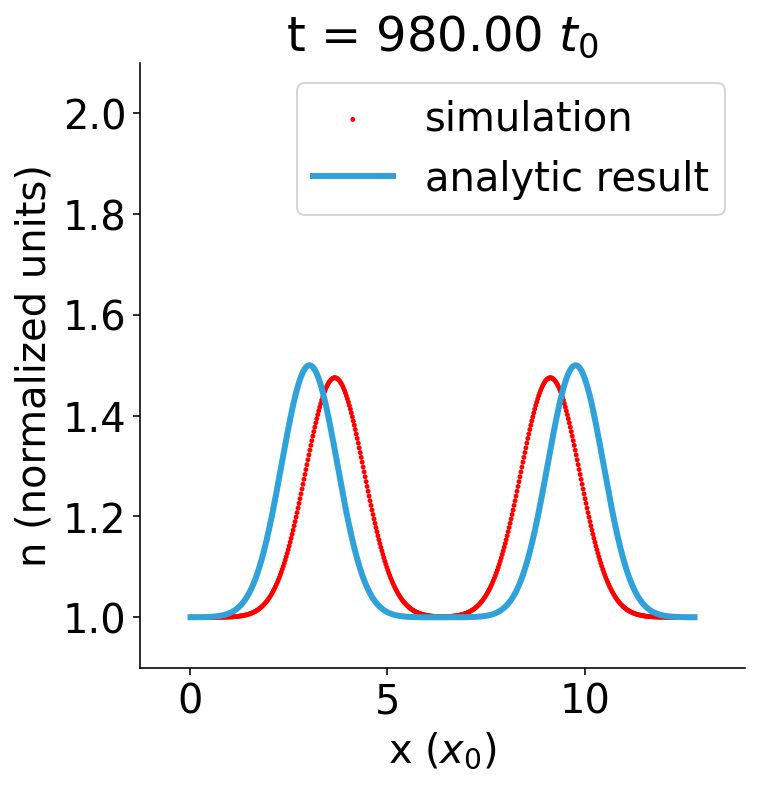
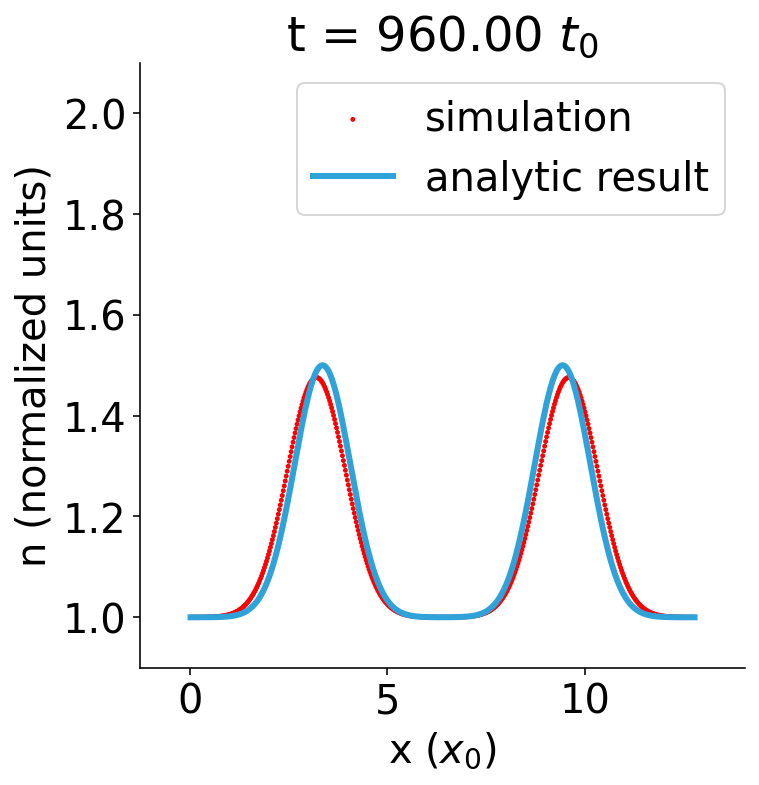
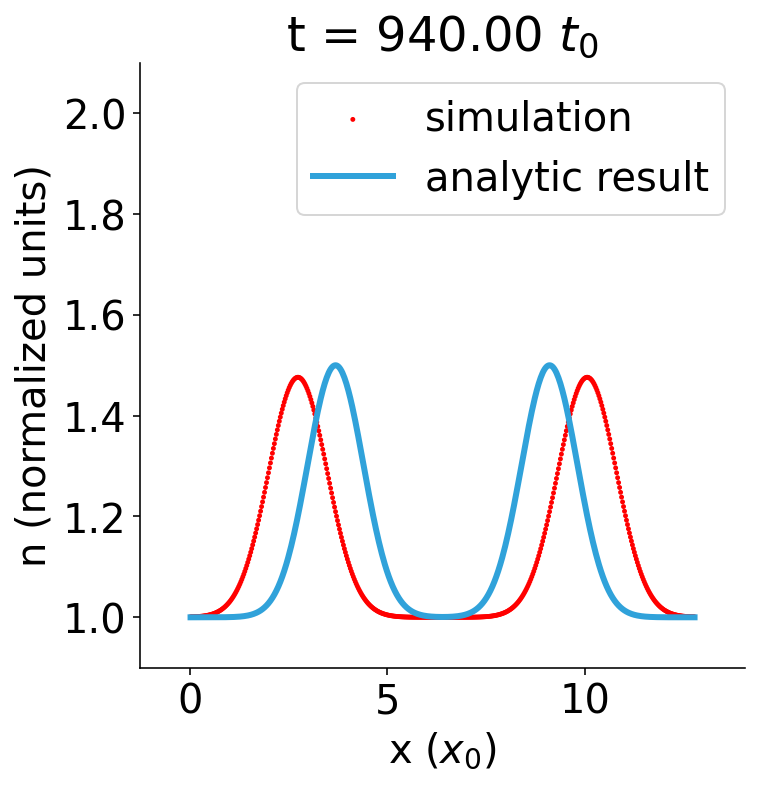
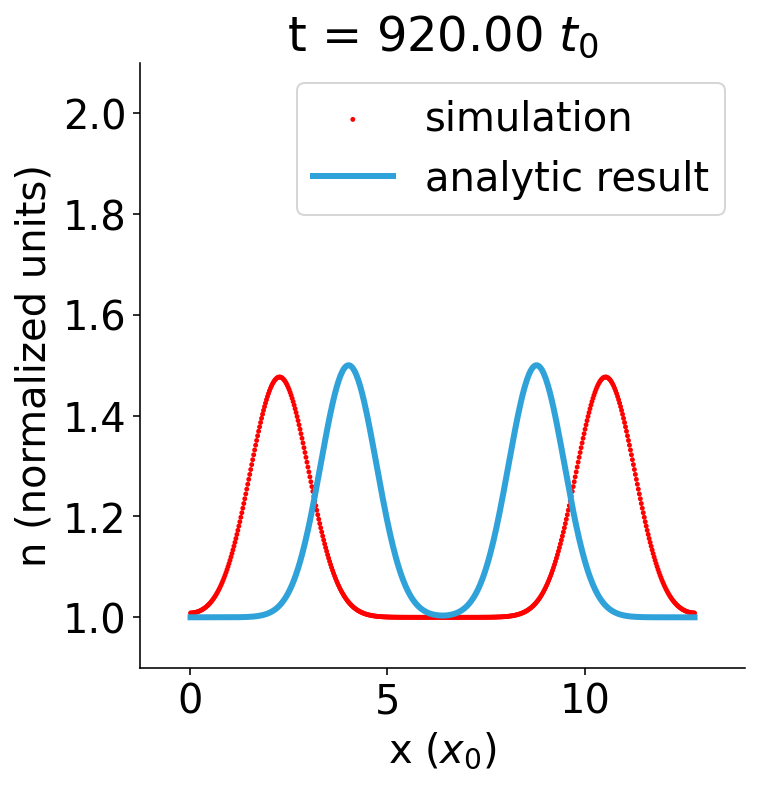
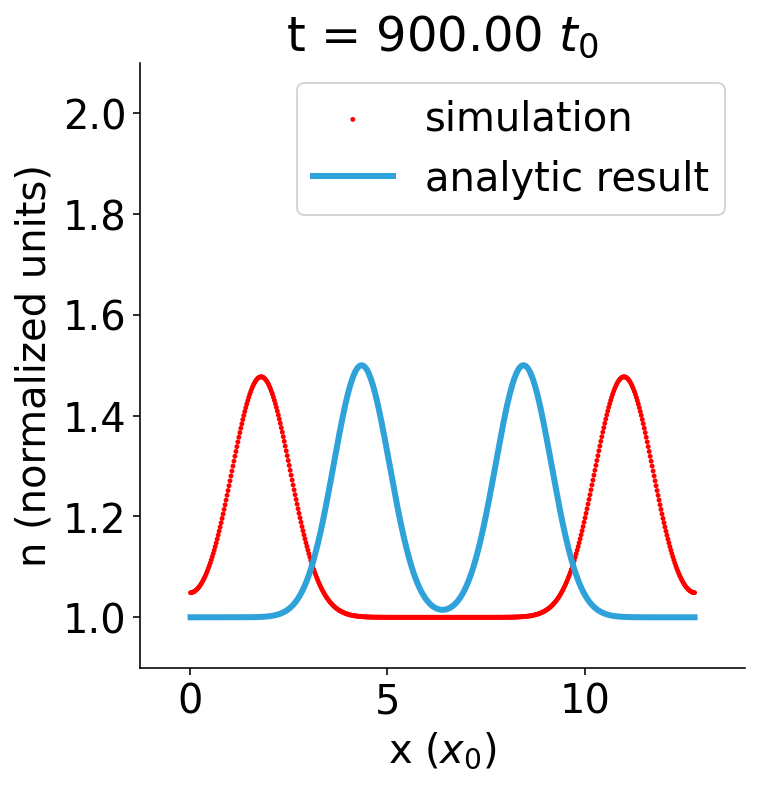
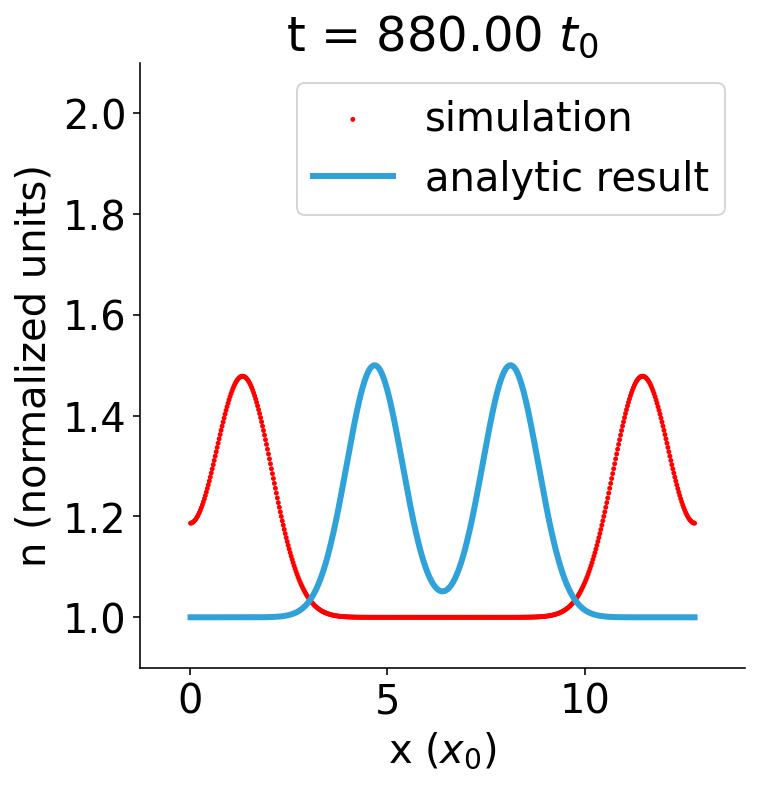
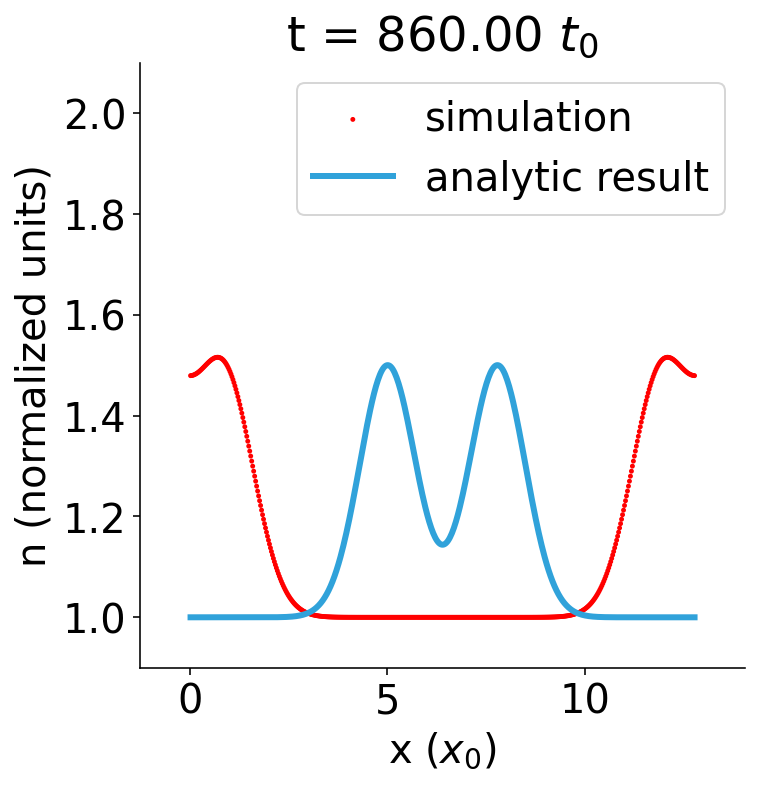
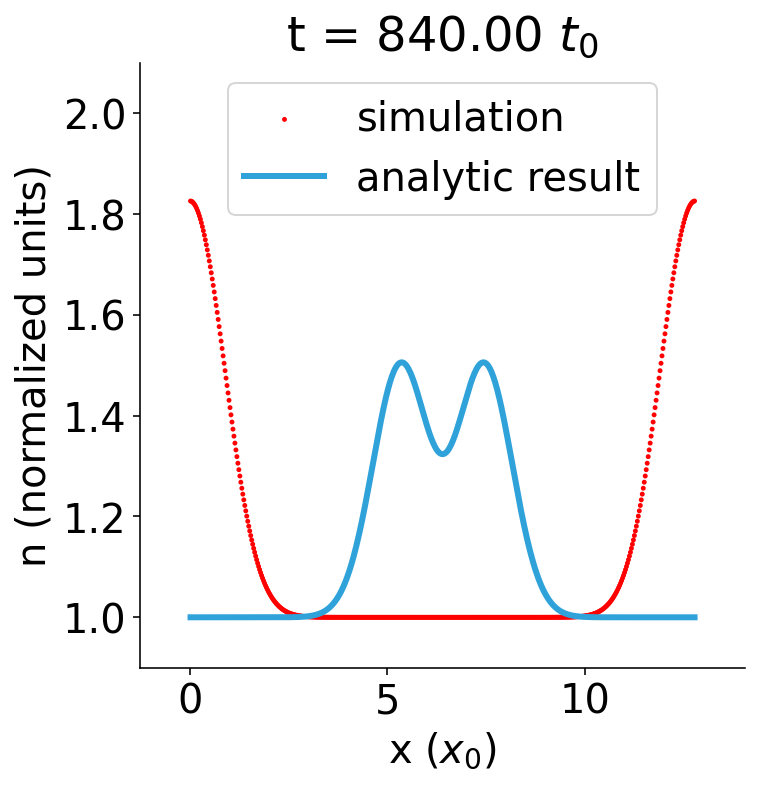
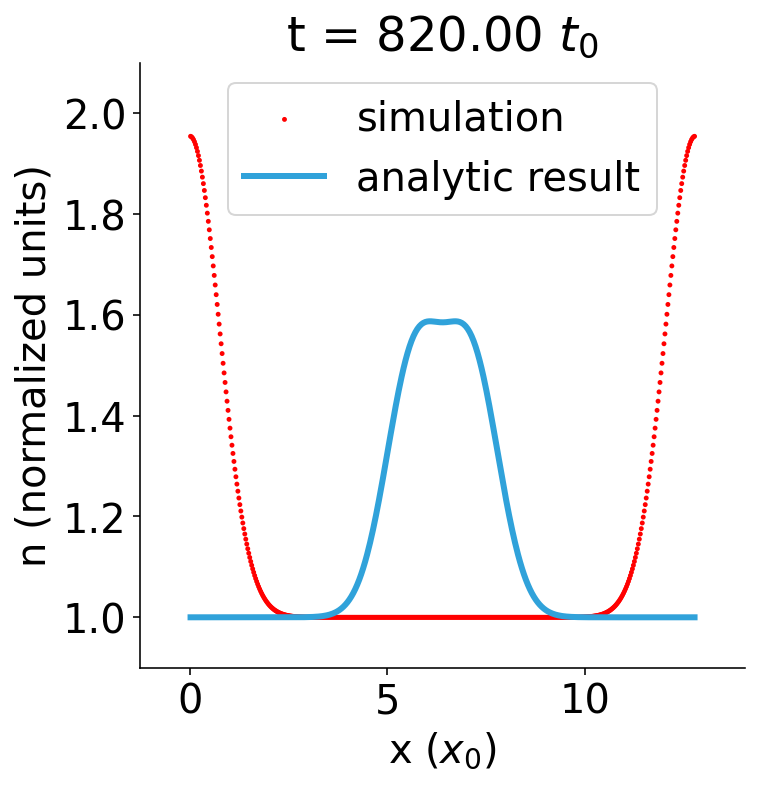
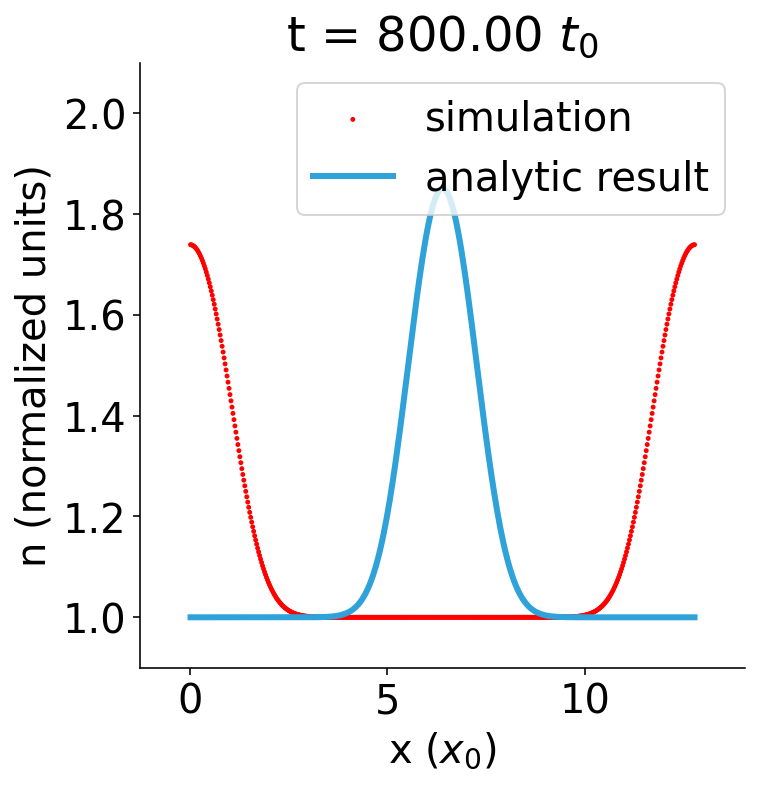
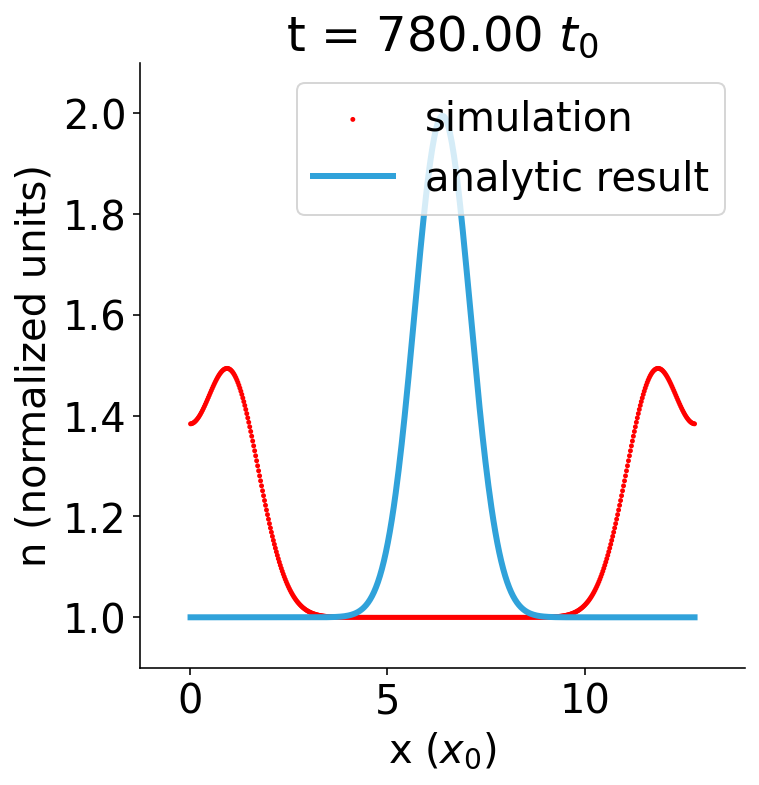
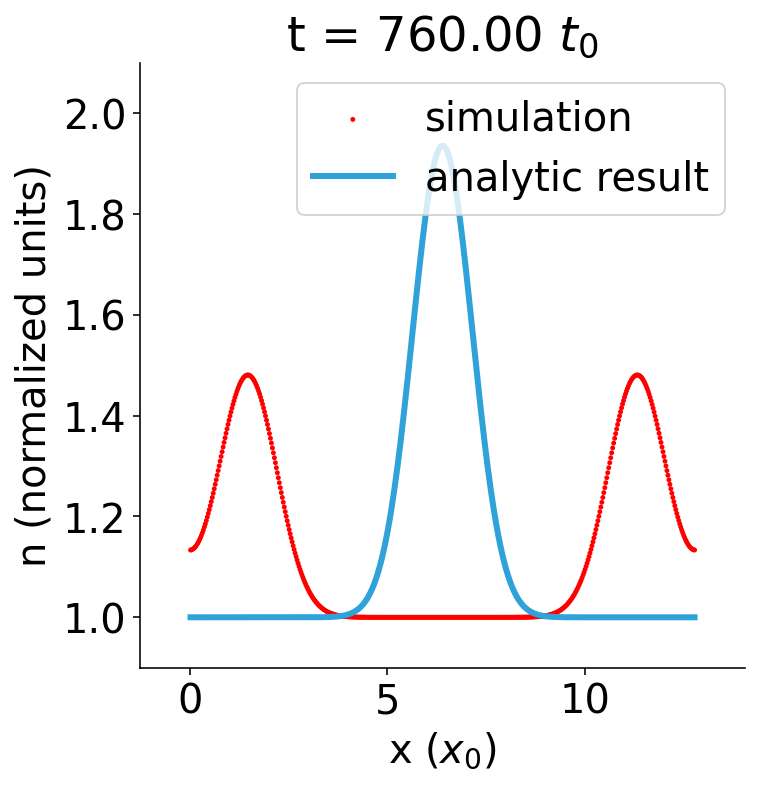
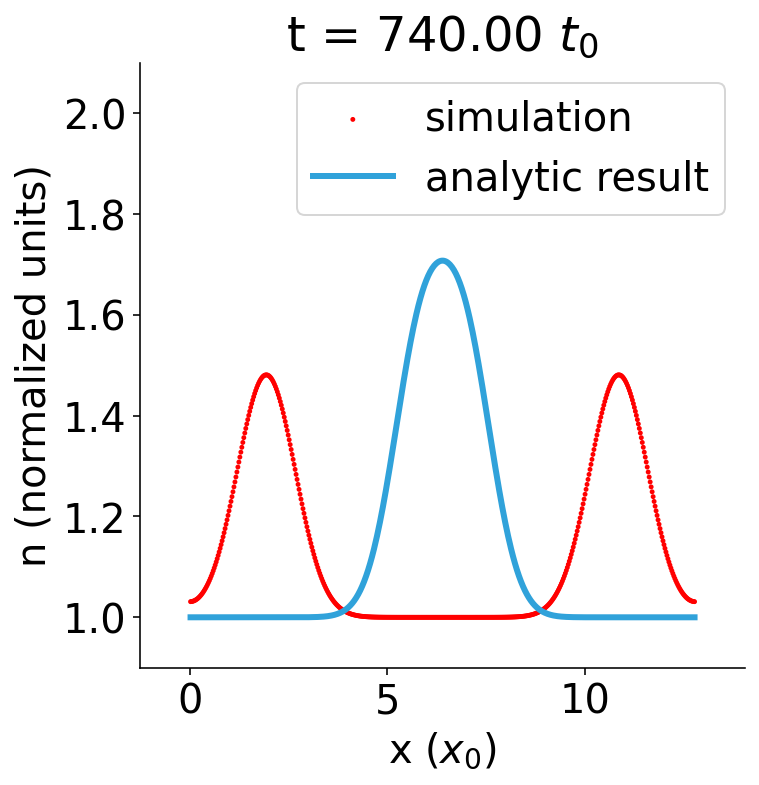
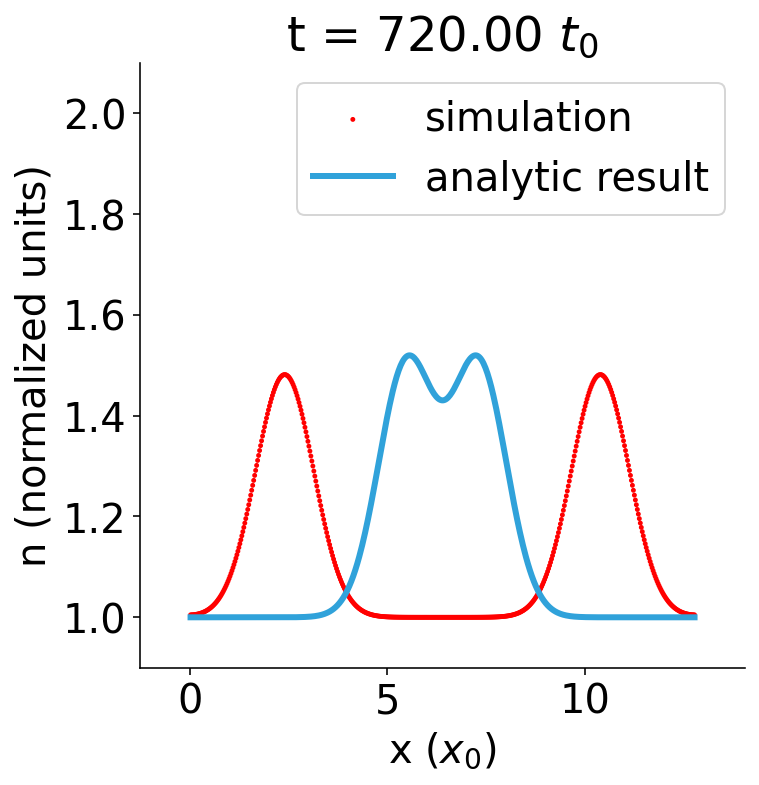
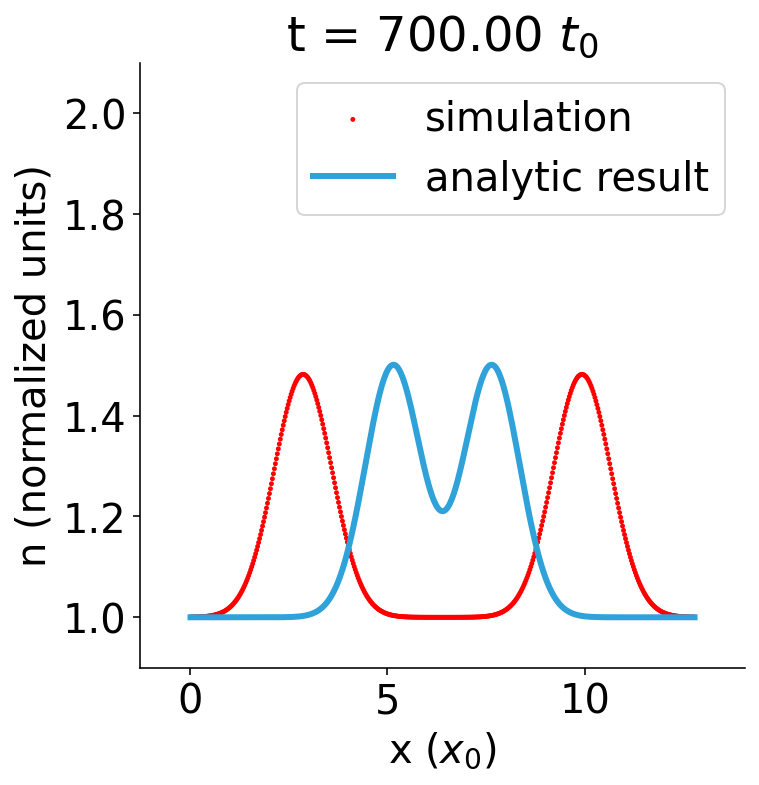
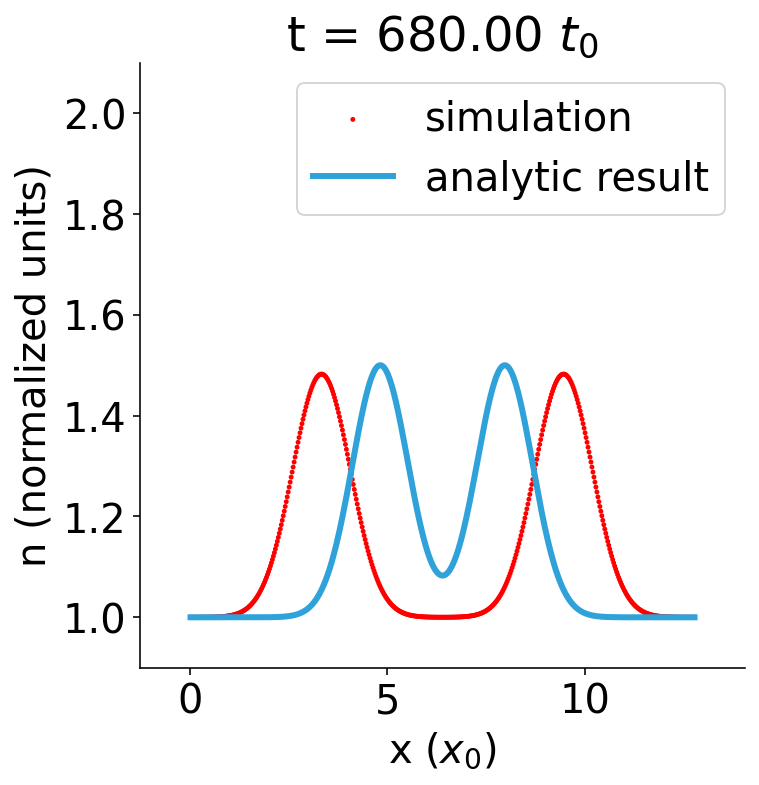
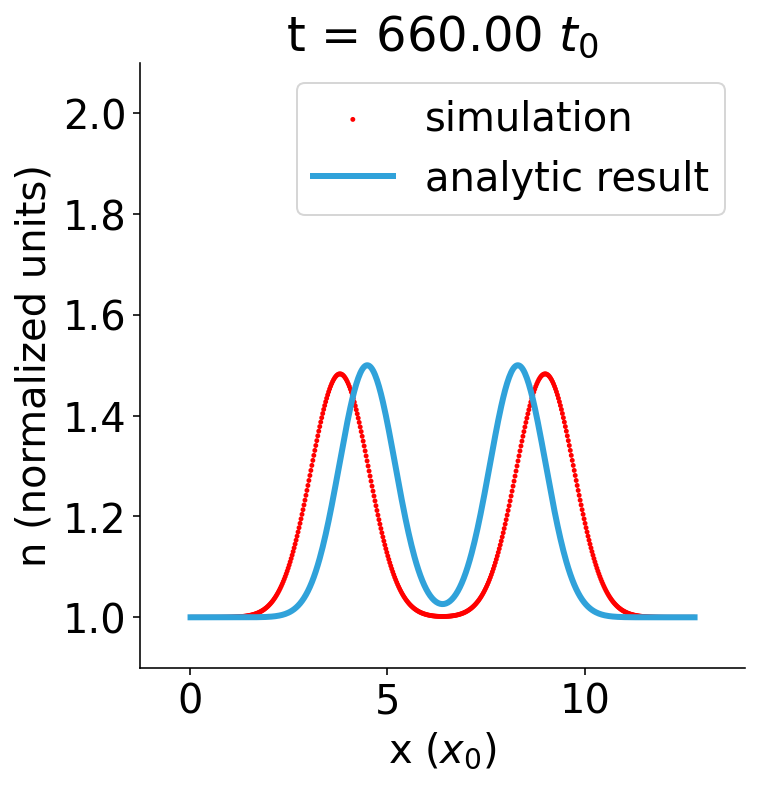
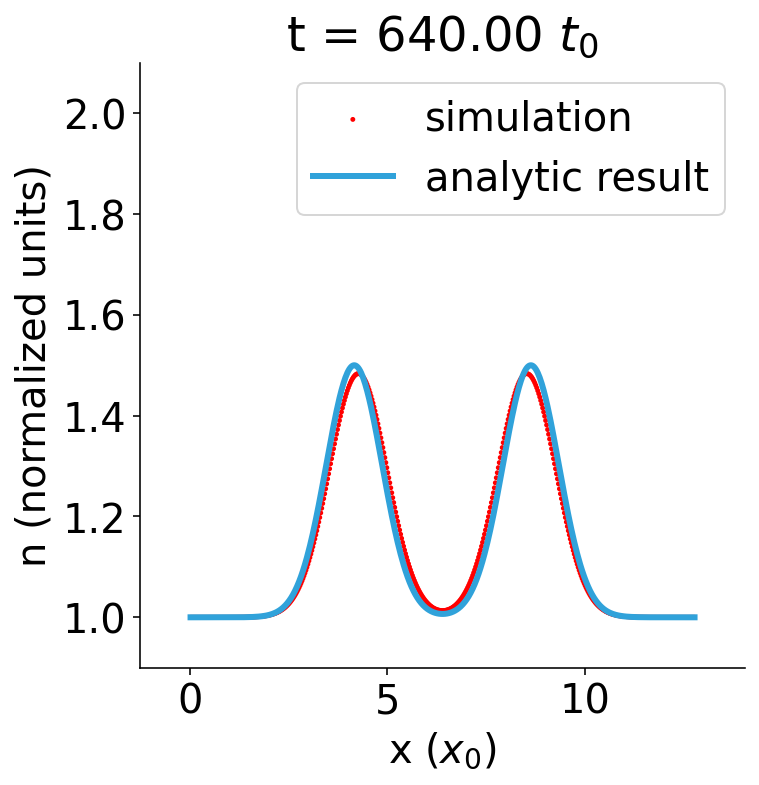
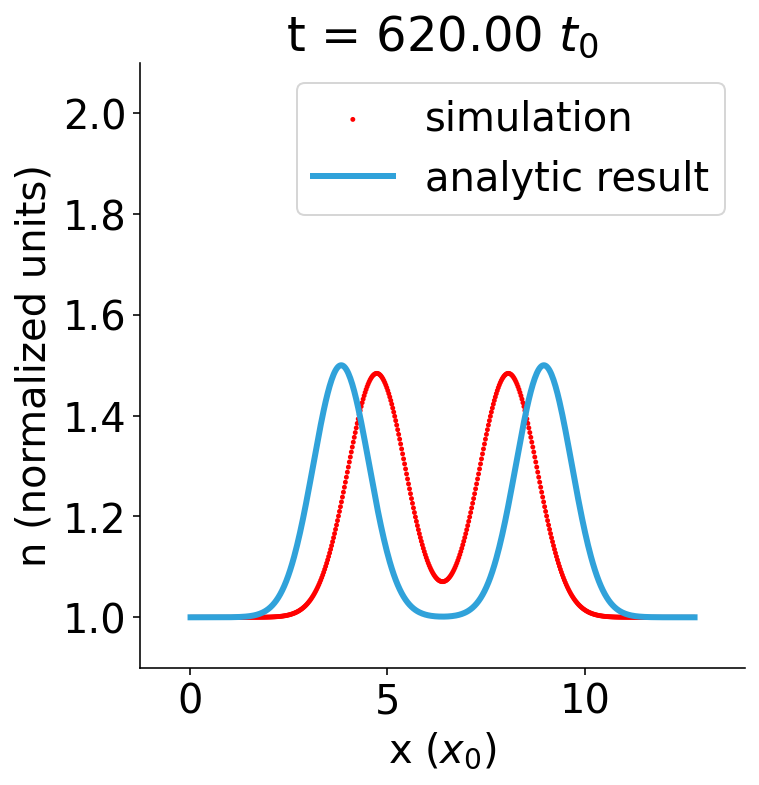
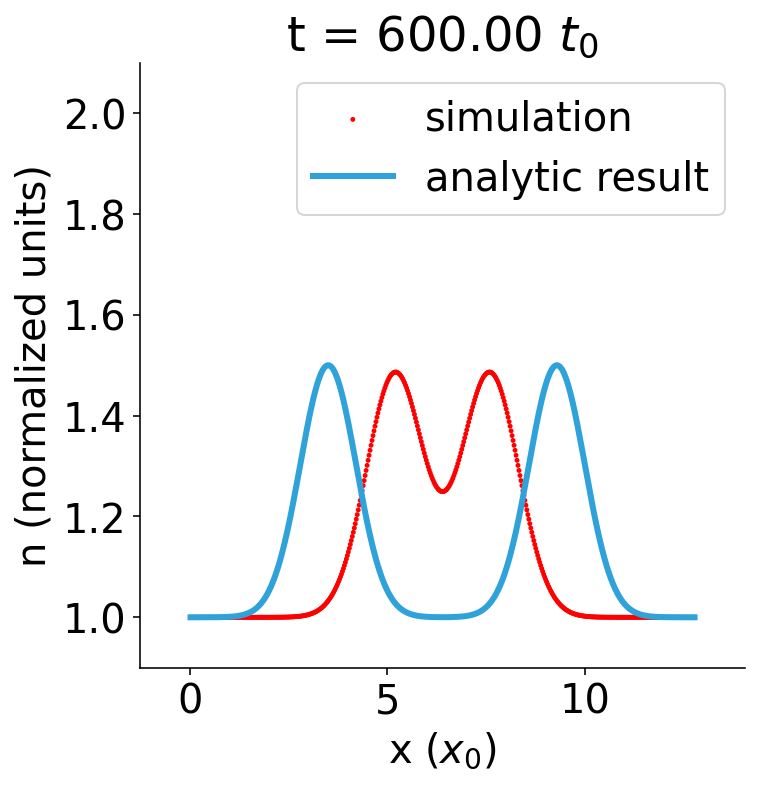
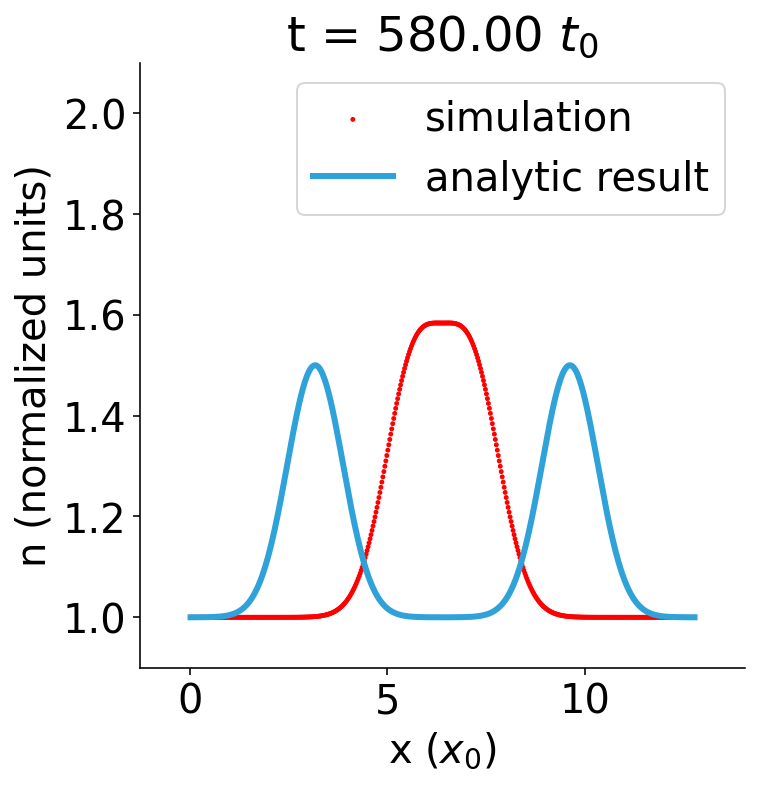
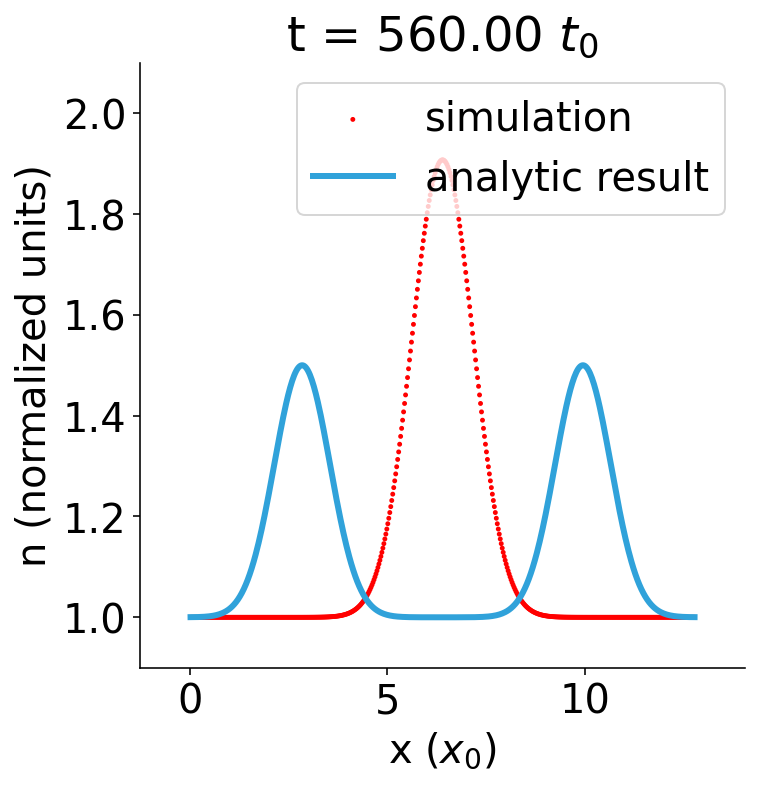
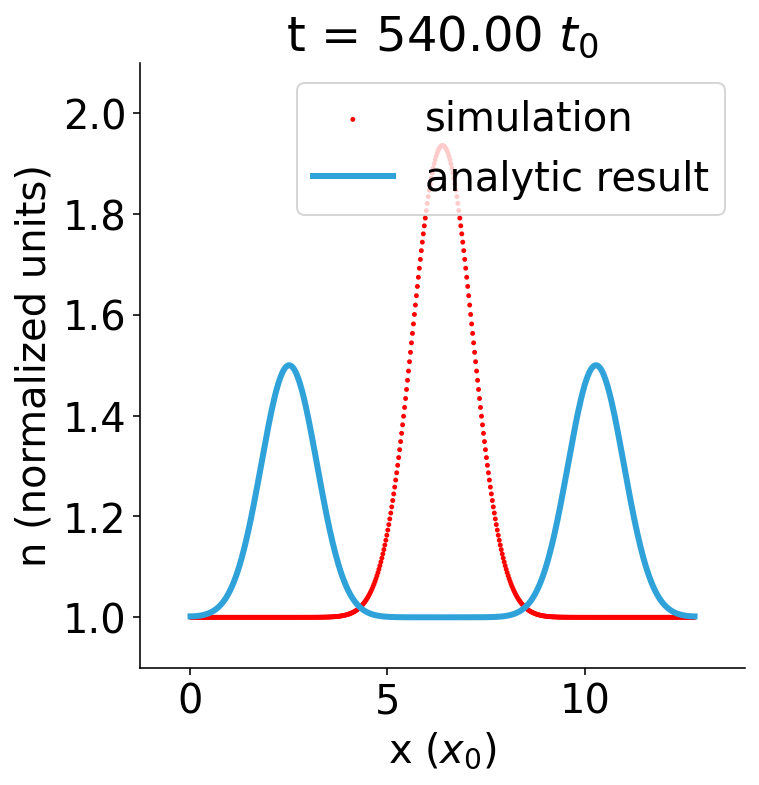
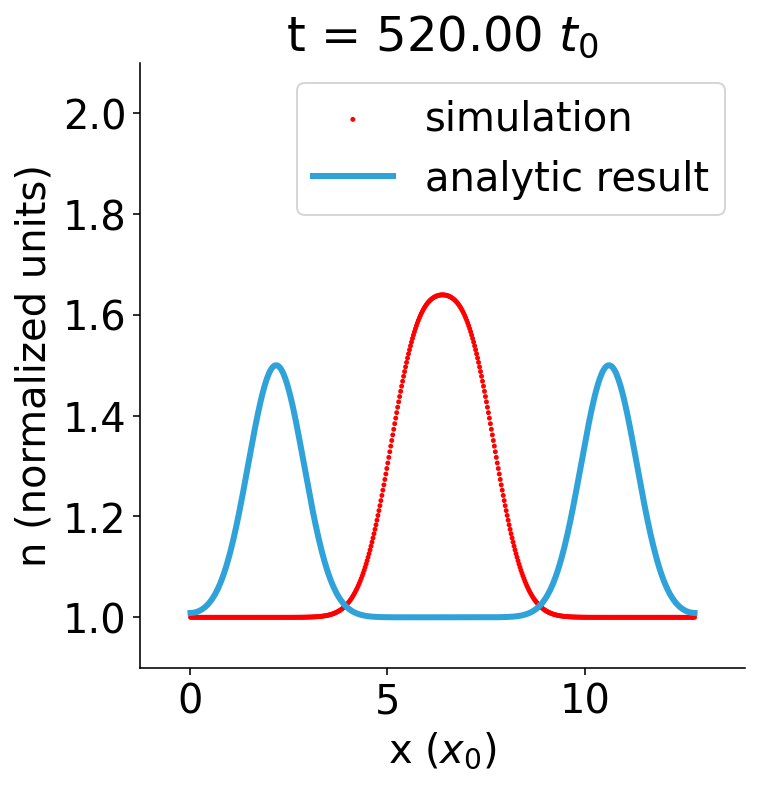
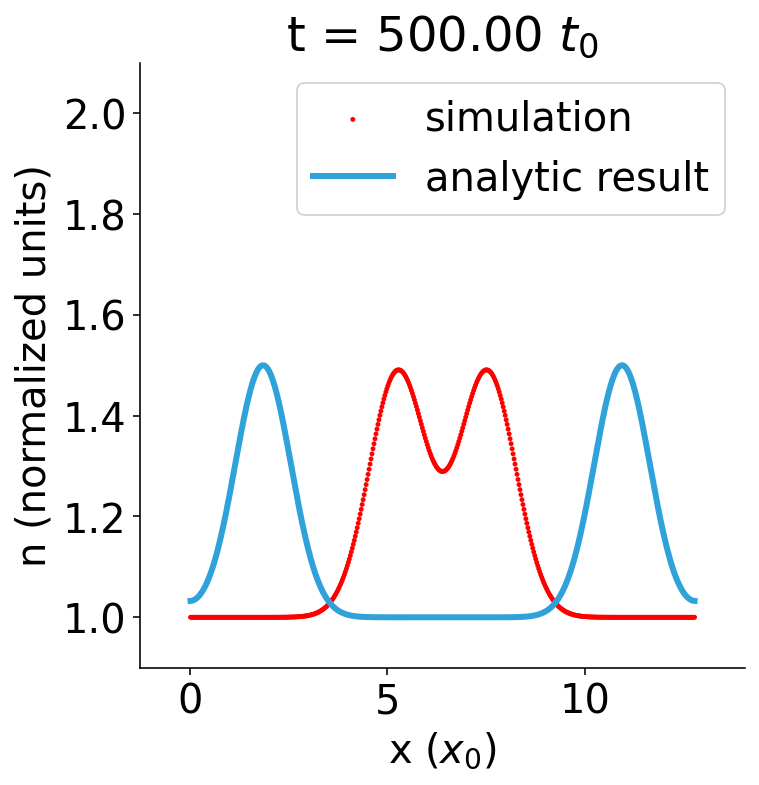
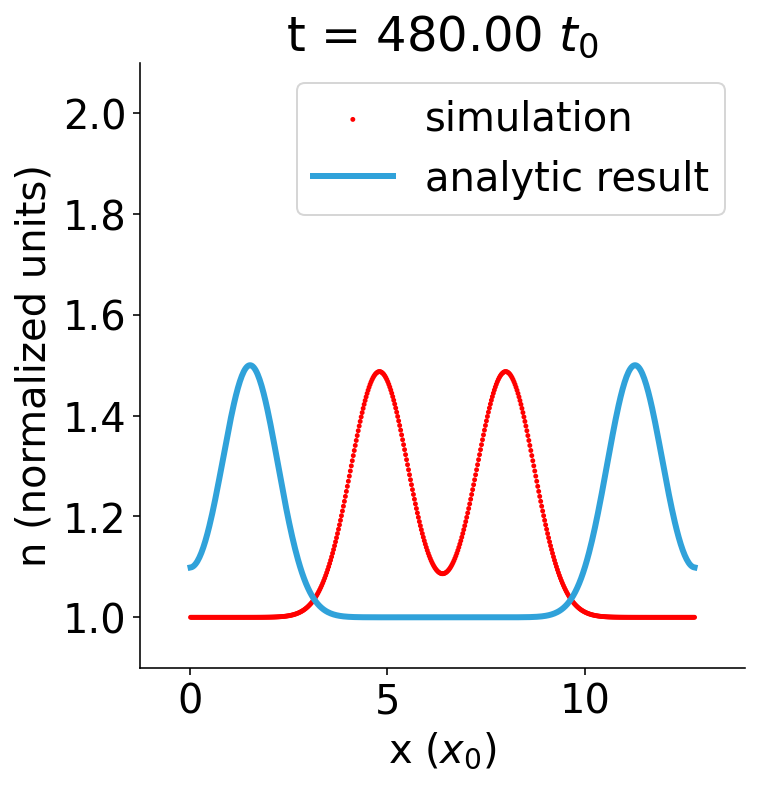
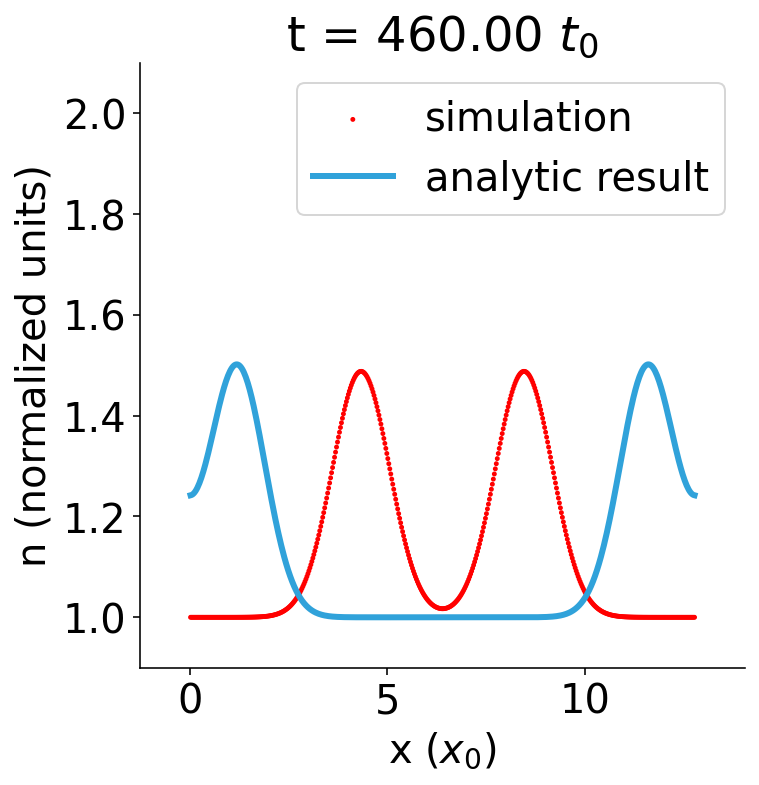
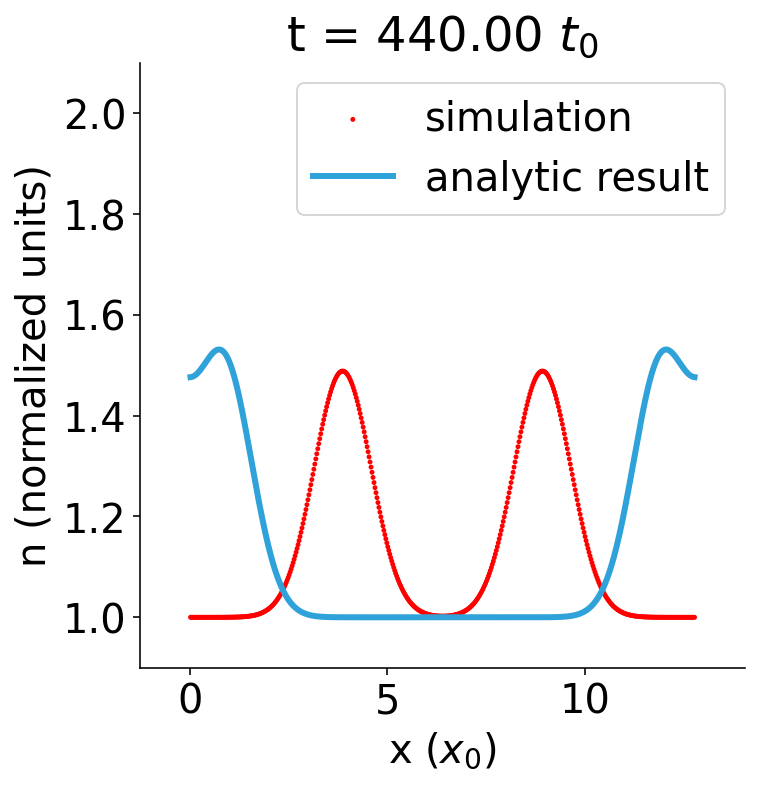
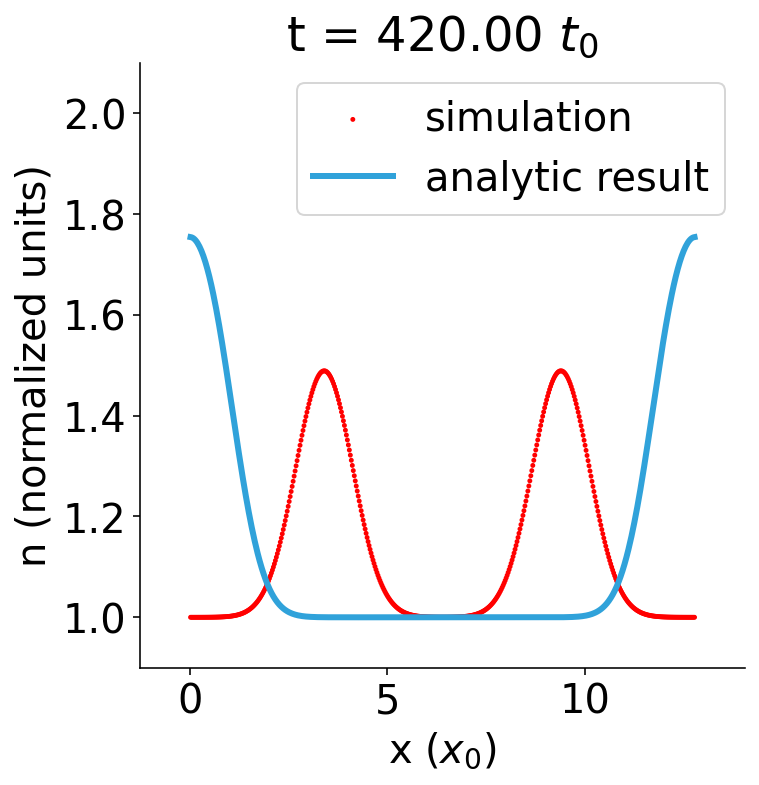
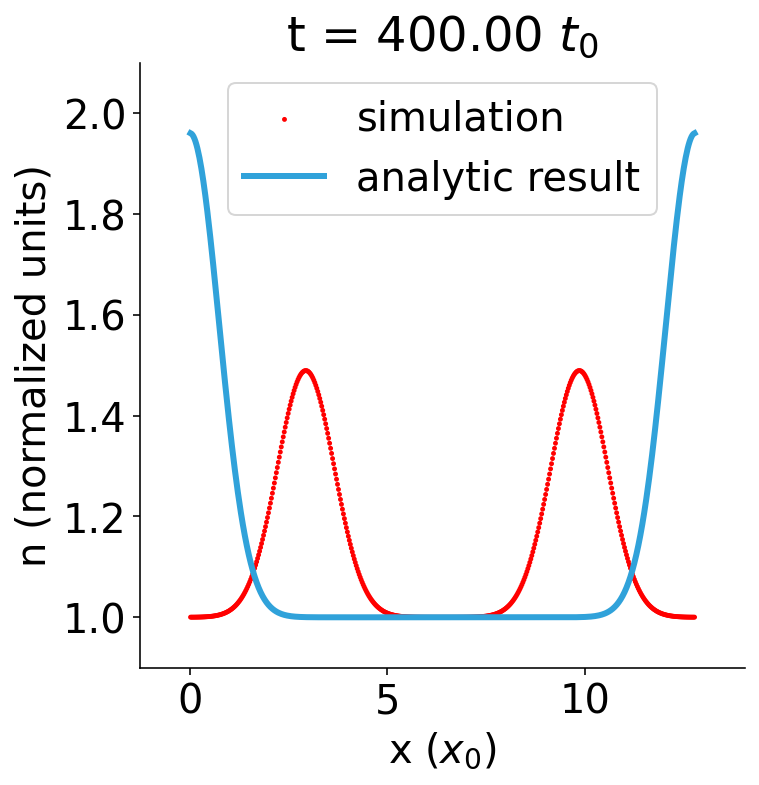
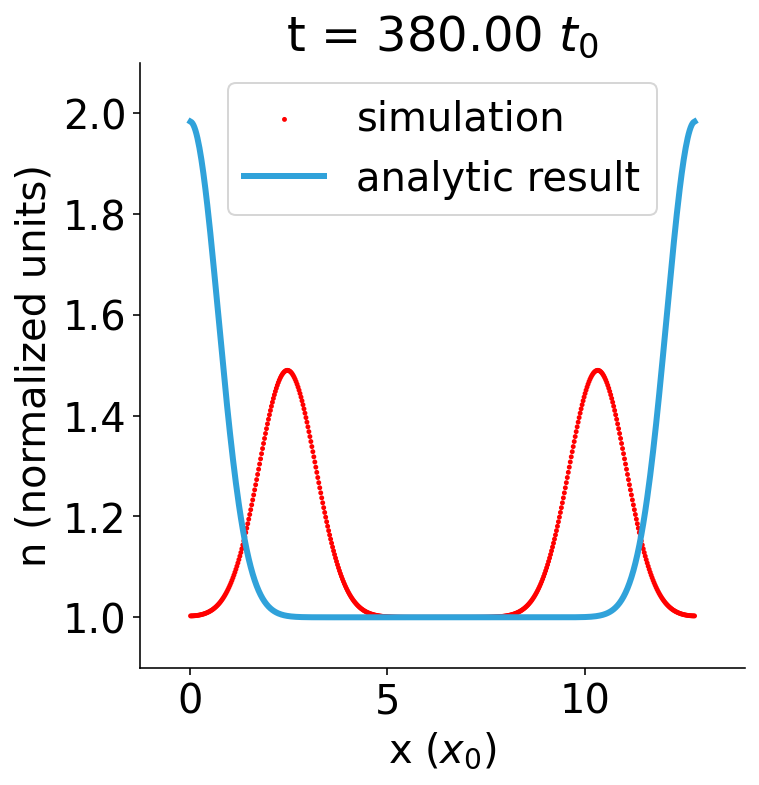
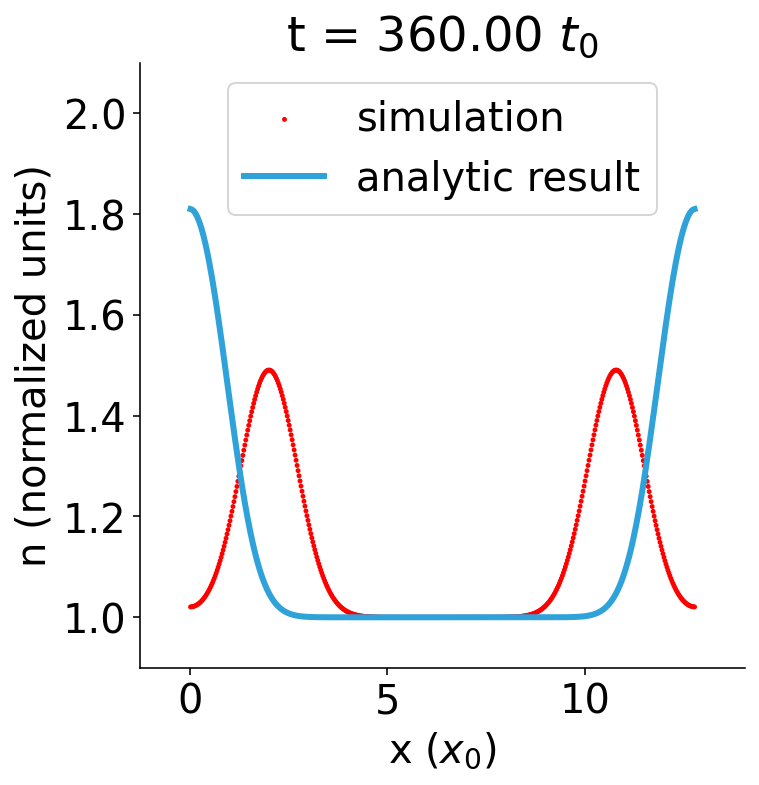
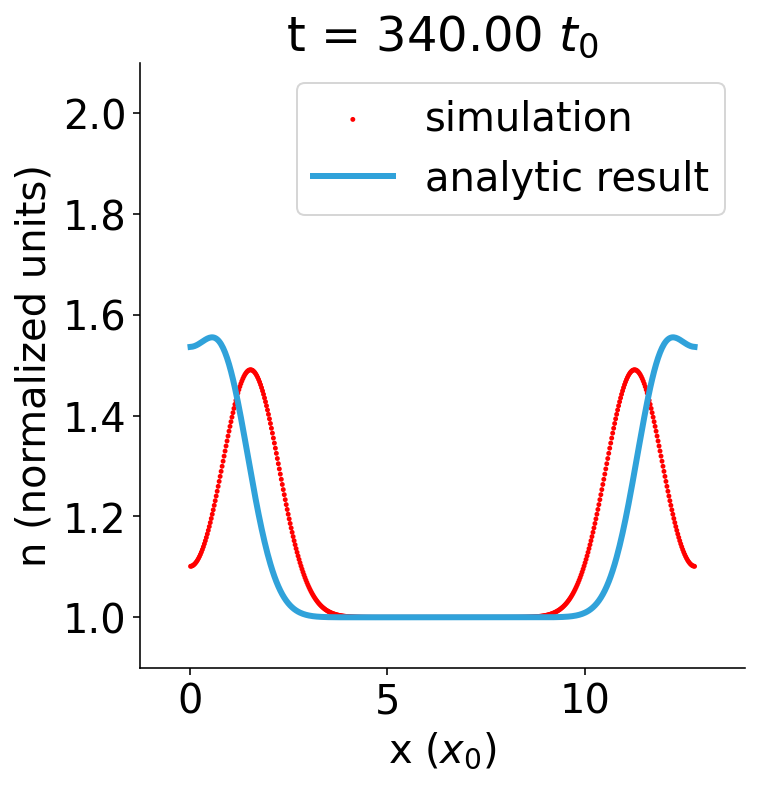
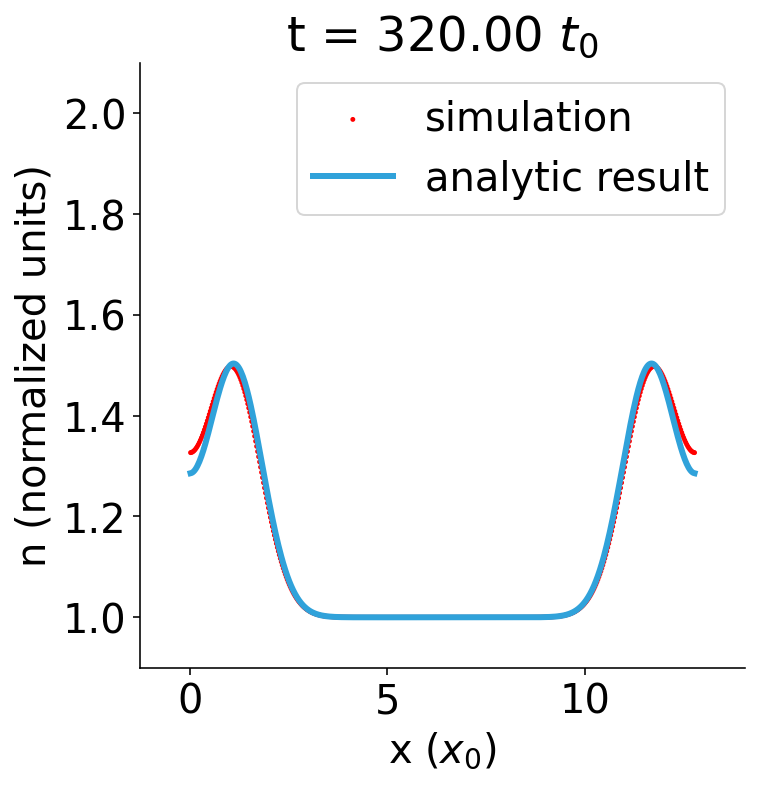
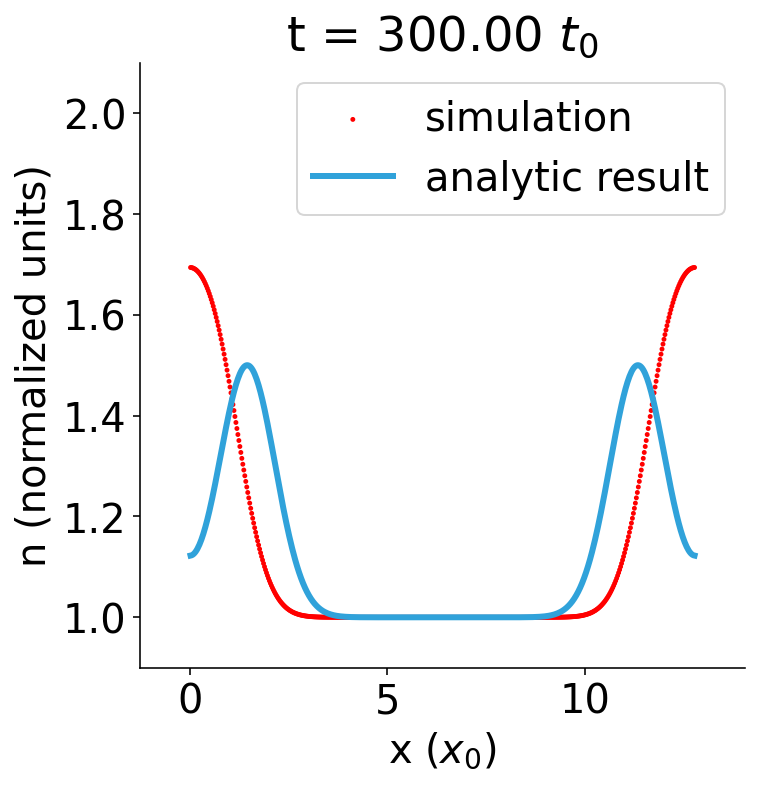
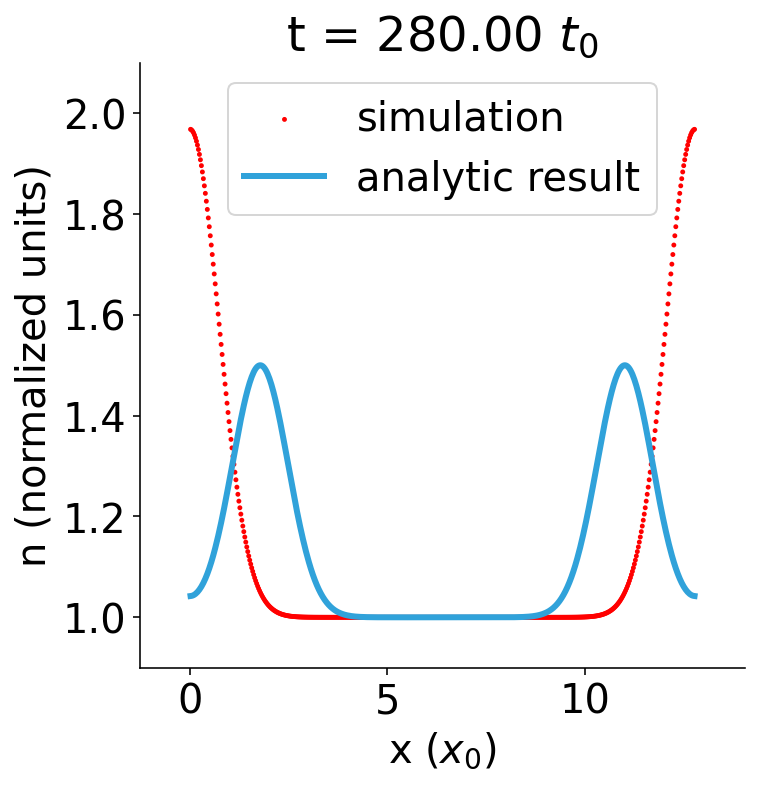
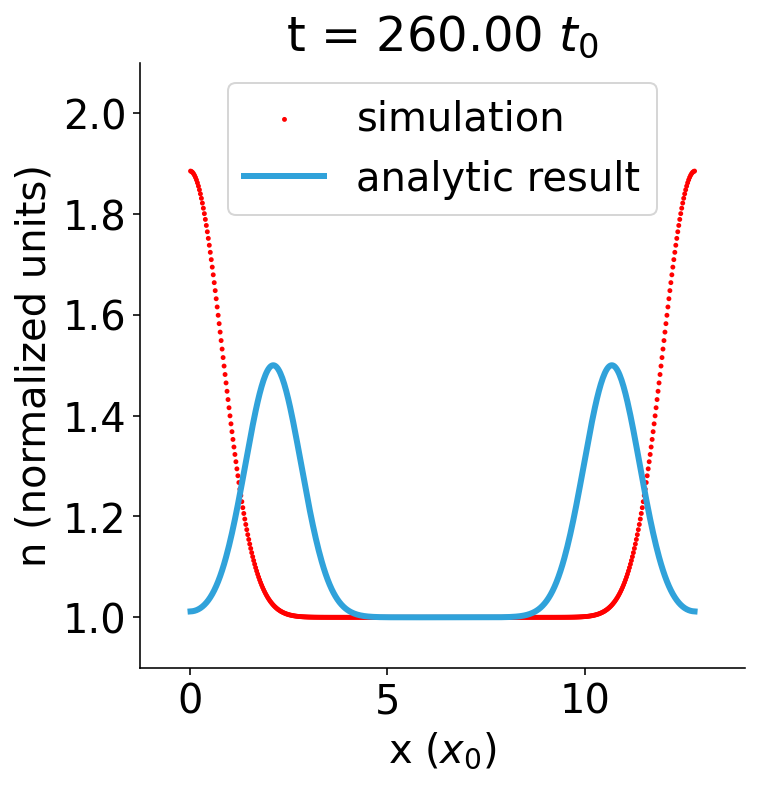
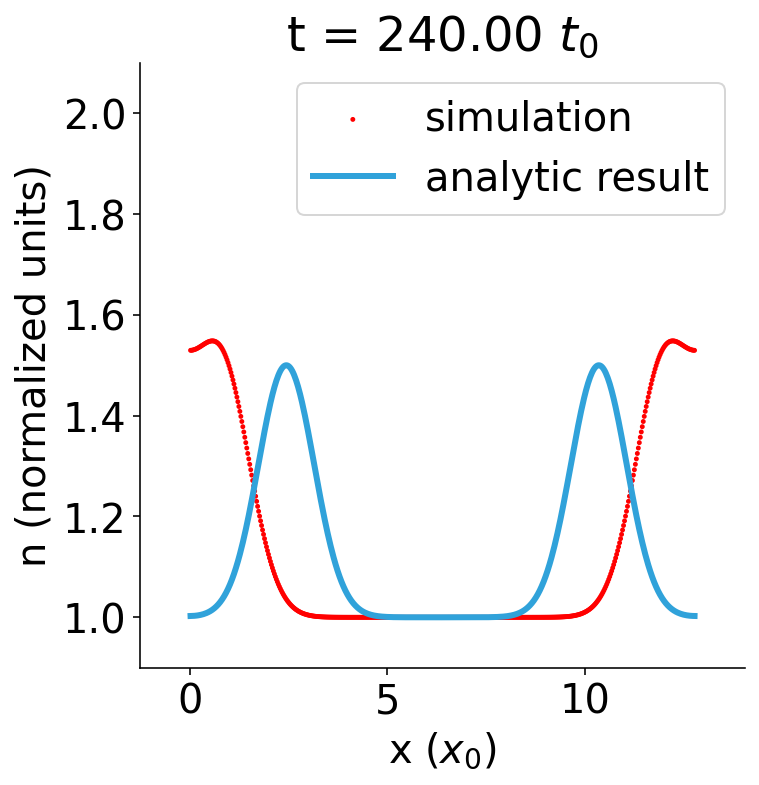
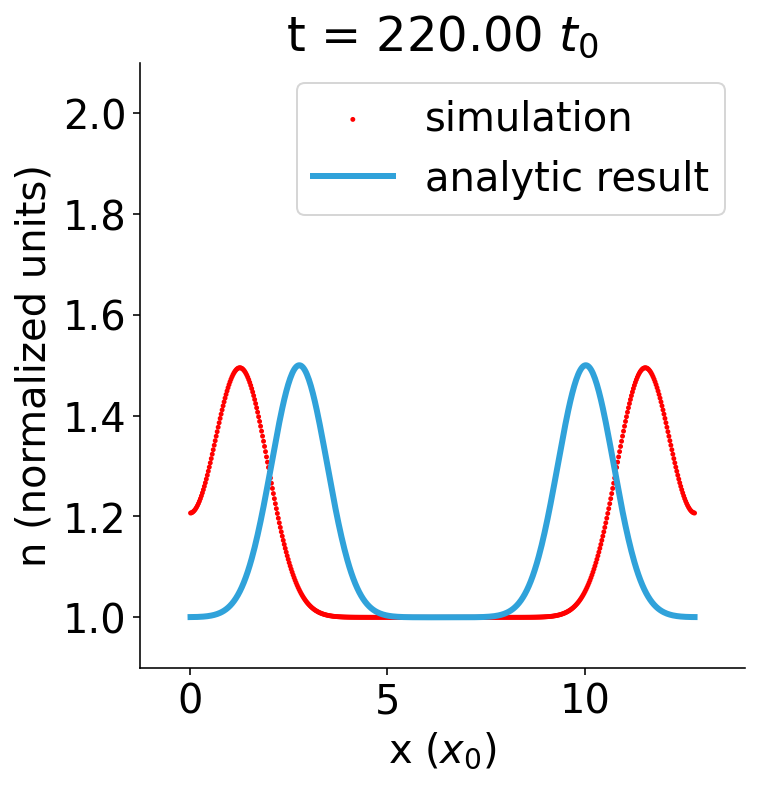
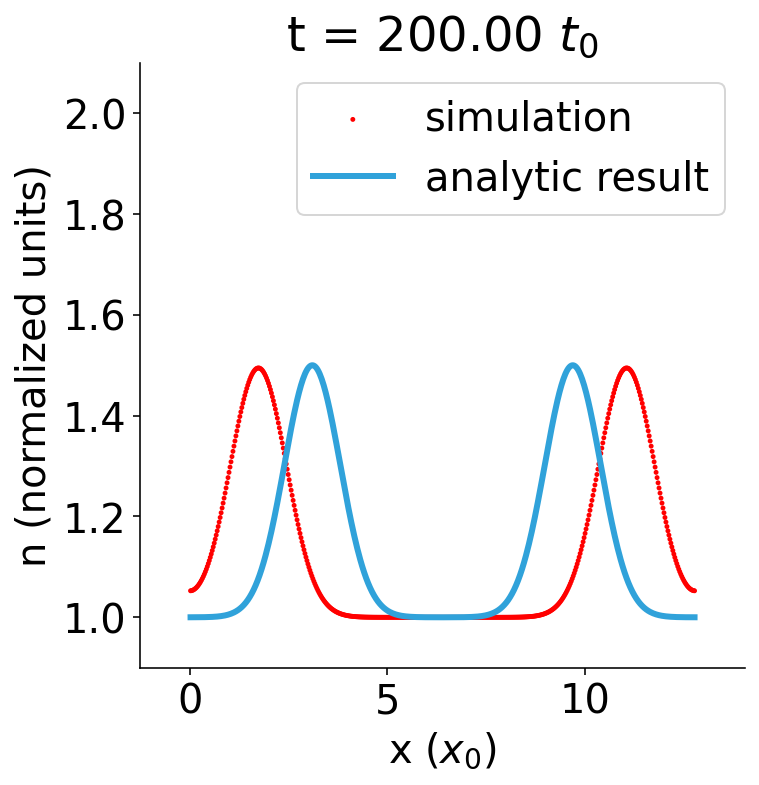
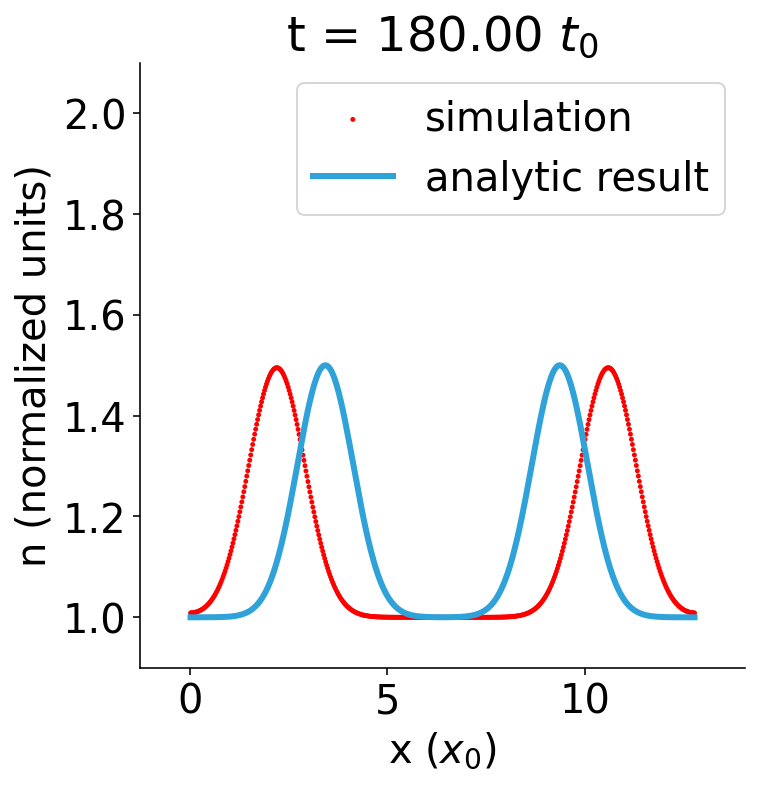
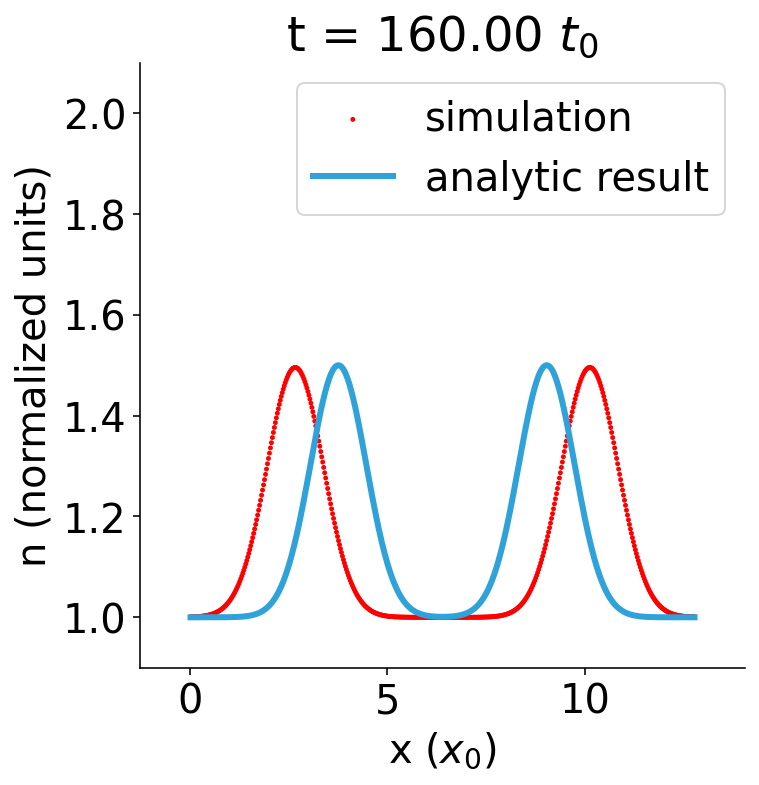
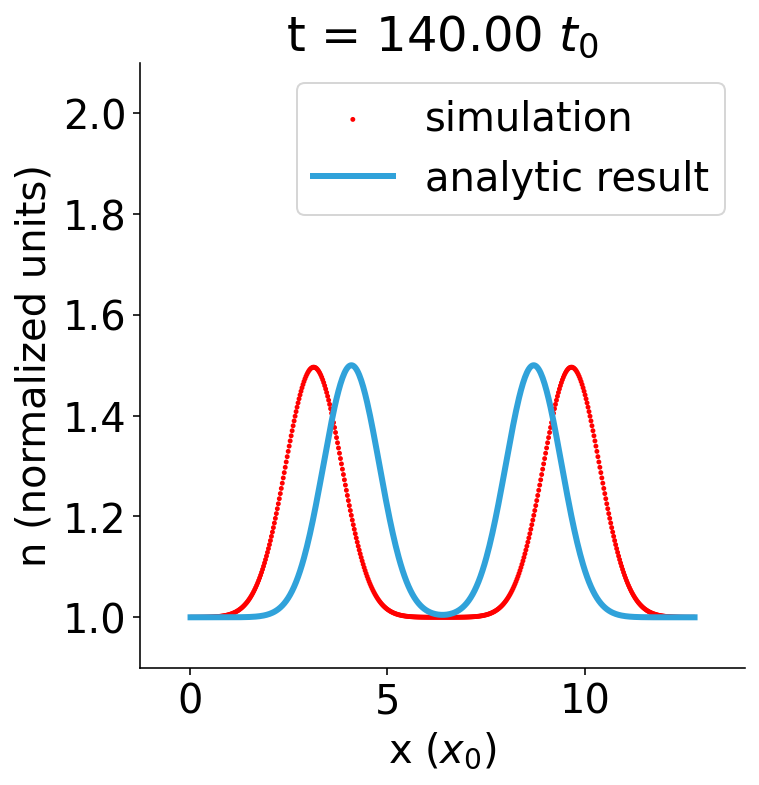
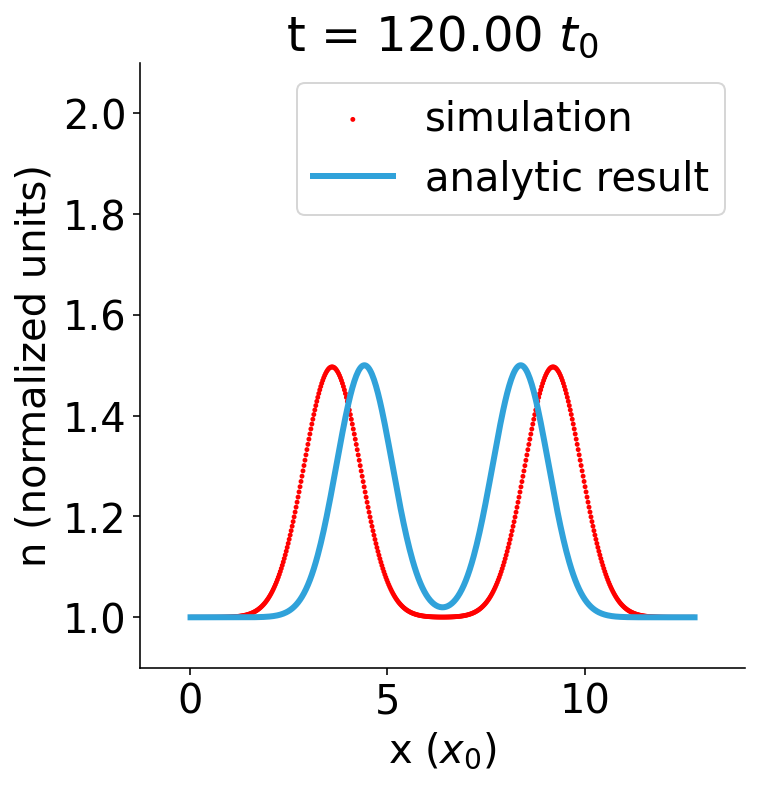
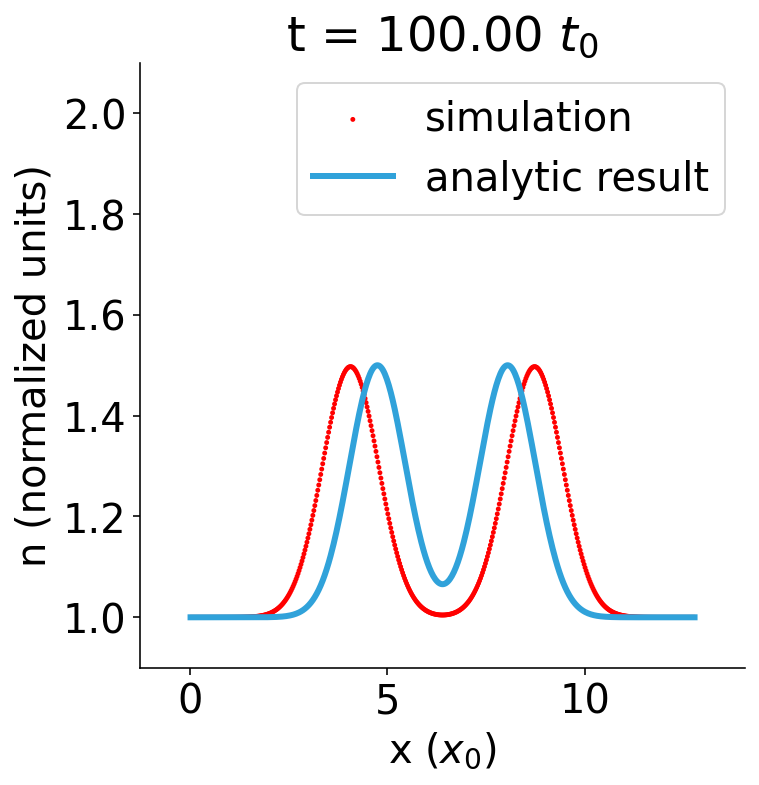
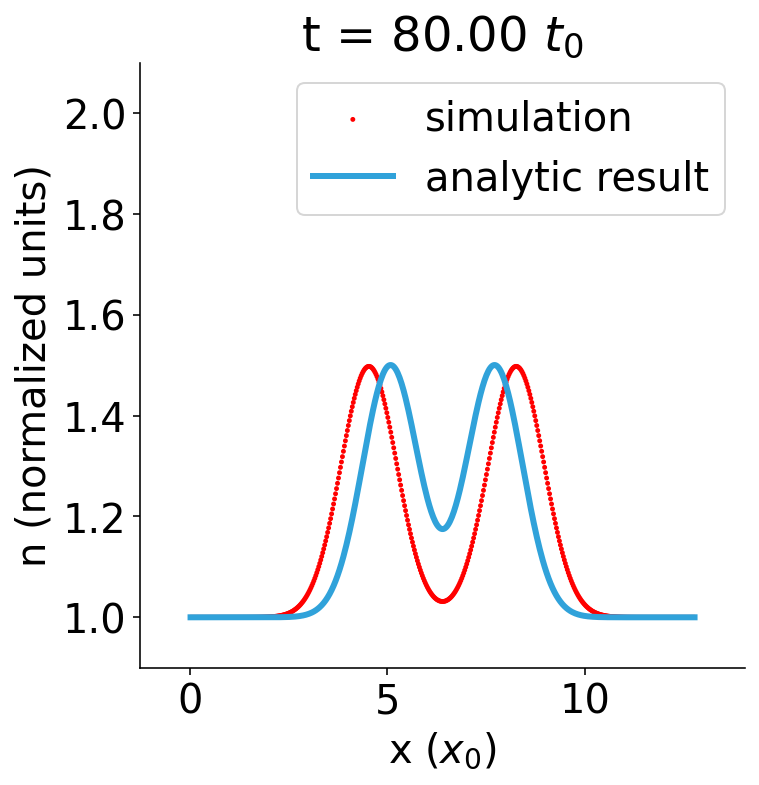
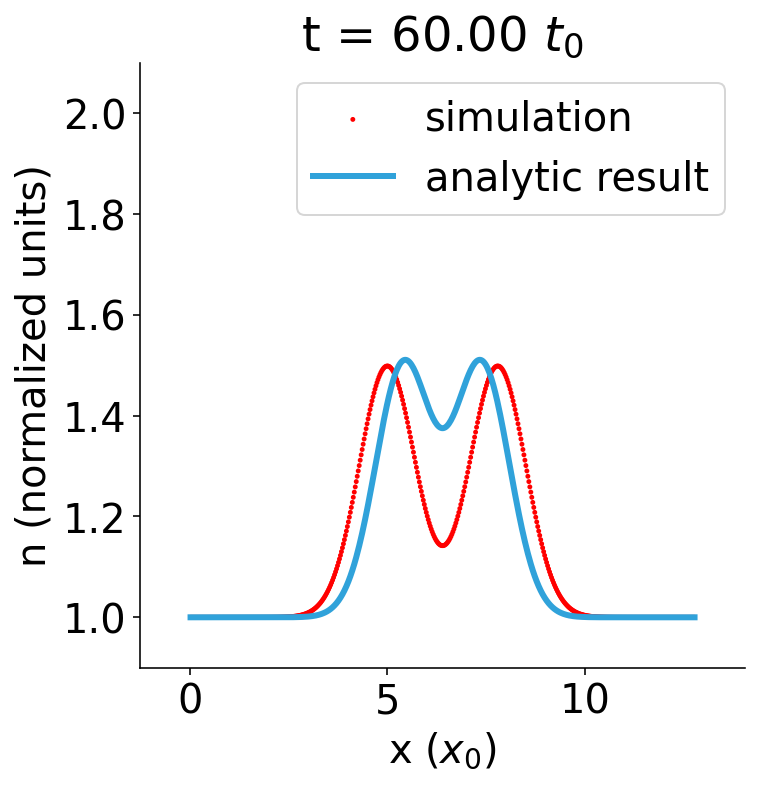
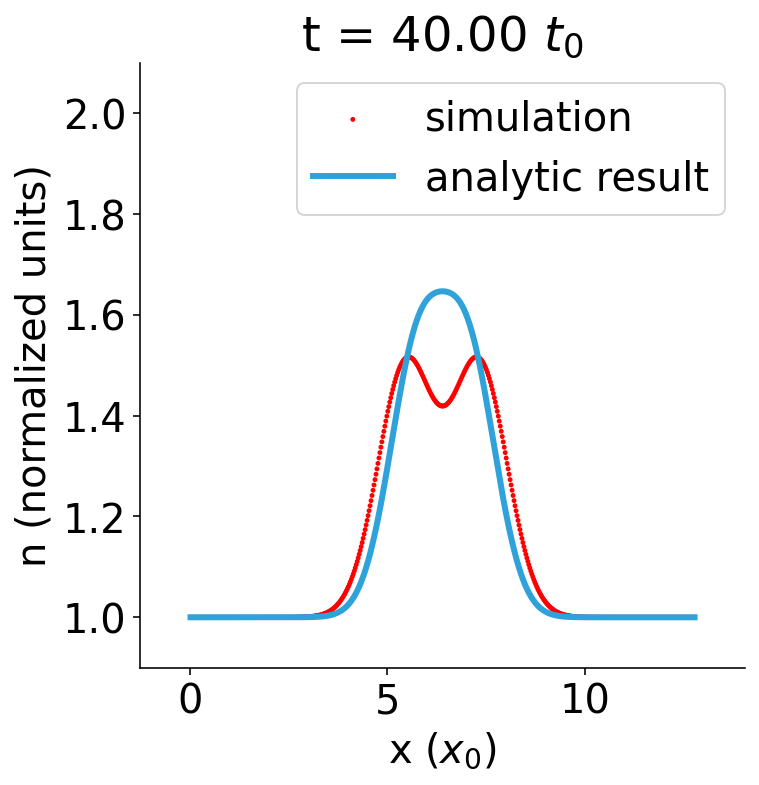
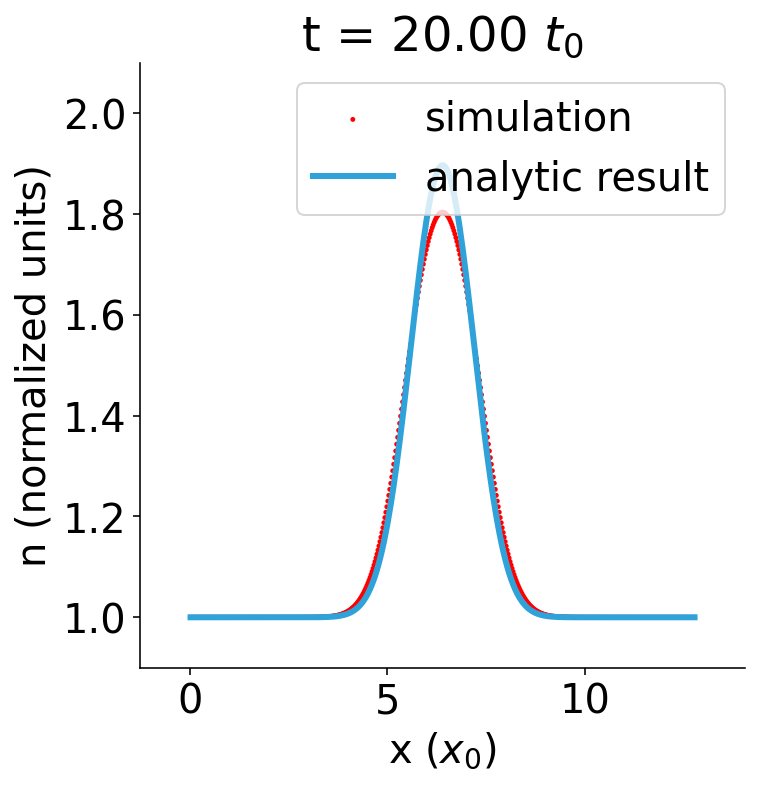
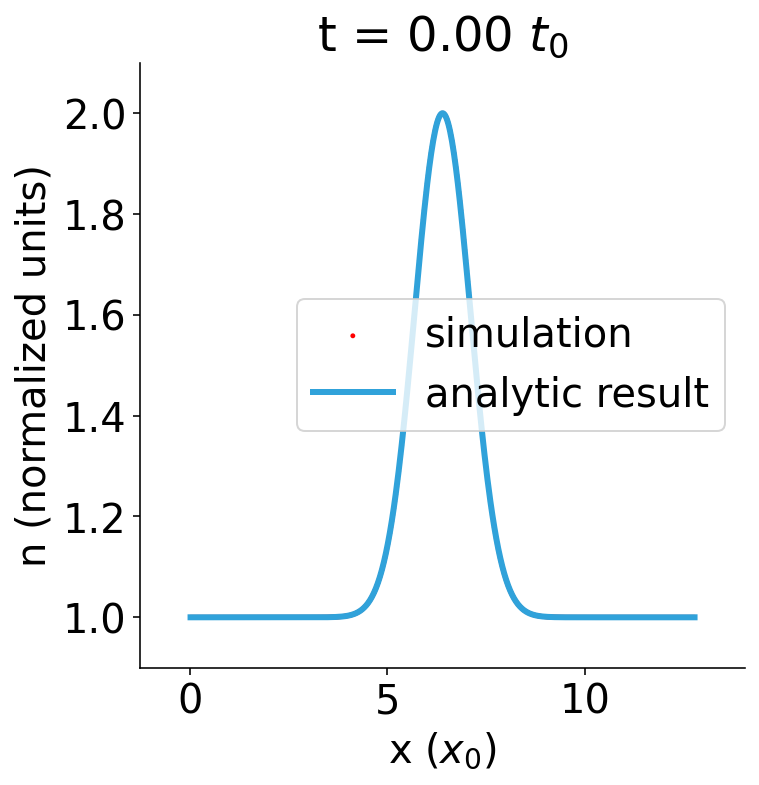

In [54]:
dataName = 'n'

curveDict = {t: hv.Scatter(loadedData[dataName][{"time":t}],label='simulation').opts(marker="o",color="r",s=6.0)*hv.Curve((gridObj.xGrid,n_analytic[t,:]),label='analytic result').opts(title=f't = {loadedData["time"].values[t]:.2f} '+loadedData.coords["time"].attrs["units"],fontscale=2, fig_size=150,linewidth=3.0) for t in range(numFiles+1)}
kdims = [hv.Dimension(('time', 'Time'),unit=loadedData.coords["time"].attrs["units"], default=0)]
hv.HoloMap(curveDict,kdims=kdims).opts()